In [1]:
# pip install adjustTexta

In [2]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
ppp = os.path.abspath('../../visualization')

sys.path.insert(1, p)
sys.path.insert(1, pp)
sys.path.insert(1, ppp)



In [3]:
import sys, os

from utils.statistics import *
from utils.settings import *
from distribution_collector import collect_tag_distributions

from utils.constants import CONSTANTS
import seaborn as sns

import numpy as np
import json, pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import ks_2samp

import datetime

import itertools
import networkx as nx

import statsmodels.api as sm
import networkx as nx

import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
colors = plt.get_cmap('tab20').colors 



In [4]:
input_dir = '../../visualization/result/bert_based/difficulty_annotated/data'
output_dir = './fig/'
date_range = 'Daily'

In [5]:
tag_info = load_json("../../visualization/result/tag/tag_info.json")
all_tags = list(tag_info.keys())

In [6]:
diff_dict = {'0':'Basic', '1':'Intermediate', '2':'Advanced'}

In [7]:
tot_df = pd.DataFrame()
for f in os.listdir(input_dir):
    js = load_json(f'{input_dir}/{f}')
    df = pd.DataFrame(js)
    tot_df = pd.concat([tot_df, df], axis=0)
    #     data = pd.read_csv(f, encoding = 'euc-kr')
    #     print(data.head())

In [8]:
tot_df.head()

,id,creationdate,title,tags,body,Document,Topic,difficulty
0,77011759,2023-08-30 22:01:13.597000,Math domain error when simplifying radicals,<python><math><square-root>,<p>I am attempting to create a function in Pyt...,I am attempting to create a function in Python...,15,0
1,77011809,2023-08-30 22:11:25.720000,Debian 11 : pip is configured with locations t...,<python><ssl><installation><pip><pyenv>,<p>I've installed Python 3.11 in Debian 11 but...,I've installed Python 3.11 in Debian 11 but af...,29,2
2,77012106,2023-08-30 23:39:49.527000,Django Allauth - ModuleNotFoundError: No modul...,<python><python-3.x><django><django-allauth><d...,<p>&quot;ModuleNotFoundError: No module named ...,""";ModuleNotFoundError: No module named 'allaut...",12,1
3,77012115,2023-08-30 23:42:26.333000,Using plotly express px.bar causes a shift in ...,<python><time-series><plotly><bar-chart><plotl...,<p>I am trying to print a bar chart using plot...,I am trying to print a bar chart using plotly ...,1,0
4,77008560,2023-08-30 13:36:10.017000,How to make Kivy app stay in the Task Bar on c...,<python><kivy>,<p>How to make the Kivy app stay in the Task B...,How to make the Kivy app stay in the Task Bar ...,7,1


In [9]:
# for diff in diff_dict.keys():
#     diff_df = tot_df[tot_df['difficulty'] == diff]

In [10]:
tot_t_list = tot_df[['id', 'creationdate', 'difficulty', 'tags']].copy()
tot_t_list.loc[:, 'tags_list'] = tot_t_list['tags'].apply(lambda x : x.replace('><', ' ').replace('<', '').replace('>', '').split(' '))
tot_t_list['tags_list'] = tot_t_list['tags_list'].apply(lambda x : list(itertools.product((x), repeat=2)))
tot_t_list['tags_list'] = tot_t_list['tags_list'].apply(lambda x :sorted(x))

In [11]:
# diff_t_list = 
tot_t_list = tot_t_list.explode('tags_list')

In [12]:
tot_t_list.head()

,id,creationdate,difficulty,tags,tags_list
0,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(math, math)"
0,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(math, python)"
0,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(math, square-root)"
0,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(python, math)"
0,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(python, python)"


In [13]:
tot_t_list['tags_for_n'] = tot_t_list['tags_list'].apply(lambda x : '' if x[0]==x[1] else x)

In [14]:
tot_t_list = tot_t_list[tot_t_list['tags_for_n'] != ''].reset_index(drop=True)

In [15]:
tot_t_list['tag_from'] = tot_t_list['tags_for_n'].apply(lambda x : x[0])
tot_t_list['tag_to'] = tot_t_list['tags_for_n'].apply(lambda x : x[1])

In [16]:
tot_t_list['creationdate'] = pd.to_datetime(tot_t_list['creationdate'], format="mixed").dt.date

In [17]:
tot_t_list['ymon'] = tot_t_list['creationdate'].apply(lambda x: str(x)[:7])

In [18]:
tot_t_list

,id,creationdate,difficulty,tags,tags_list,tags_for_n,tag_from,tag_to,ymon
0,77011759,2023-08-30,0,<python><math><square-root>,"(math, python)","(math, python)",math,python,2023-08
1,77011759,2023-08-30,0,<python><math><square-root>,"(math, square-root)","(math, square-root)",math,square-root,2023-08
2,77011759,2023-08-30,0,<python><math><square-root>,"(python, math)","(python, math)",python,math,2023-08
3,77011759,2023-08-30,0,<python><math><square-root>,"(python, square-root)","(python, square-root)",python,square-root,2023-08
4,77011759,2023-08-30,0,<python><math><square-root>,"(square-root, math)","(square-root, math)",square-root,math,2023-08
...,...,...,...,...,...,...,...,...,...
127555,73563592,2022-09-01,2,<python><kivy><kivymd>,"(kivy, python)","(kivy, python)",kivy,python,2022-09
127556,73563592,2022-09-01,2,<python><kivy><kivymd>,"(kivymd, kivy)","(kivymd, kivy)",kivymd,kivy,2022-09
127557,73563592,2022-09-01,2,<python><kivy><kivymd>,"(kivymd, python)","(kivymd, python)",kivymd,python,2022-09
127558,73563592,2022-09-01,2,<python><kivy><kivymd>,"(python, kivy)","(python, kivy)",python,kivy,2022-09


In [19]:
tot_t_list_0 = tot_t_list[tot_t_list['difficulty'] =='0']

In [20]:
# tot_t_list_0.groupby(['ymon', 'tags_for_n'])['id'].count().reset_index(name='count').sort_values(['ymon', 'count'], ascending=[True, False]).reset_index(drop=True).to_csv(f'../data/network/tag_chk_0.csv', index=False)


In [21]:
tot_t_list['rel_week'] = np.floor((pd.to_datetime(tot_t_list['creationdate'])- datetime.datetime(2022,11,30)).dt.days/7)

In [22]:
tot_t_list = tot_t_list[(tot_t_list['rel_week']>-53) & (tot_t_list['rel_week']<52)]

In [23]:
tot_t_list['gpt_yn'] = np.where(tot_t_list['rel_week']<0, 0, 1)

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_37904/2435980708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tot_t_list['gpt_yn'] = np.where(tot_t_list['rel_week']<0, 0, 1)


In [24]:
def make_network(tag_for_n_list) : 
    G = nx.Graph()
    G.add_edges_from(tag_for_n_list)
    return G

In [25]:
def calc_entropy(tag_for_n_list) : 
    G = make_network(tag_for_n_list)
    # 각 노드의 degree 구하기
    
    degrees = np.array([degree for _, degree in G.degree()])
    degree_sum = degrees.sum()

    # degree를 전체합으로 나눠서 확률로 변환
    p = degrees / degree_sum

    # 샤논 엔트로피 계산
    entropy = -np.sum(p * np.log(p))

    return entropy


In [26]:
tot_t_list = tot_t_list.sort_values(by = ['rel_week','difficulty', 'creationdate'])
# .groupby(['rel_week', 'difficulty'])['tags_for_n'].transform(lambda x : calc_entropy(x))

In [27]:
# tot_t_list = 
tot_t_list['entropy_for_week'] = tot_t_list.groupby(['rel_week', 'difficulty'])['tags_for_n'].transform(lambda x : calc_entropy(x.to_list()))

In [28]:
g_week_dict = dict()
for diff in diff_dict.keys():
    g_week_dict[diff] = dict()
    tmp = tot_t_list[tot_t_list['difficulty'] == diff]
    for week in tmp['rel_week'].unique():
        tmp2 = tmp[tmp['rel_week'] == week]
        g_week_dict[diff][week] = make_network([x for x in tmp2['tags_for_n']])
        

In [29]:
g_yn_dict = dict()
for diff in diff_dict.keys():
    g_yn_dict[diff] = dict()
    tmp = tot_t_list[tot_t_list['difficulty'] == diff]
    for yn in tmp['gpt_yn'].unique():
        tmp2 = tmp[tmp['gpt_yn'] == yn]
        g_yn_dict[diff][yn] = make_network([x for x in tmp2['tags_for_n']])
        

In [30]:
g_yn_dict

{'0': {0: <networkx.classes.graph.Graph at 0x38768b6a0>,
  1: <networkx.classes.graph.Graph at 0x38b273070>},
 '1': {0: <networkx.classes.graph.Graph at 0x38b9d6340>,
  1: <networkx.classes.graph.Graph at 0x38ac6a610>},
 '2': {0: <networkx.classes.graph.Graph at 0x38768ba30>,
  1: <networkx.classes.graph.Graph at 0x38ac6a5b0>}}

In [31]:
# tot_t_list = 
tot_t_list['entropy_for_gpt_yn'] = tot_t_list.groupby(['gpt_yn', 'difficulty'])['tags_for_n'].transform(lambda x : calc_entropy(x.to_list()))

In [32]:
n_entropy_for_week_viz = tot_t_list[['rel_week', 'difficulty', 'entropy_for_week']].drop_duplicates().reset_index(drop=True)
n_entropy_for_gpt_yn_viz = tot_t_list[['rel_week', 'difficulty', 'entropy_for_gpt_yn']].drop_duplicates().reset_index(drop=True)

In [33]:
tot_t_list[['gpt_yn', 'difficulty', 'entropy_for_gpt_yn']].drop_duplicates()

,gpt_yn,difficulty,entropy_for_gpt_yn
41708,0,0,5.627627
41618,0,1,6.487300
41624,0,2,5.948525
61424,1,0,5.523291
61412,1,1,6.624588
61450,1,2,6.335930


In [34]:
entropy_dict = {}
for diff in diff_dict.keys():
    tmp = n_entropy_for_week_viz[n_entropy_for_week_viz['difficulty'] == diff]
    entropy_dict[diff] = tmp['entropy_for_week'].values

In [35]:
entropy_dict_gpt = {}
for diff in diff_dict.keys():
    tmp = n_entropy_for_gpt_yn_viz[n_entropy_for_gpt_yn_viz['difficulty'] == diff]
    entropy_dict_gpt[diff] = tmp['entropy_for_gpt_yn'].values

In [36]:
def draw_scatter_line_plot(list_, wo, calc_type):
    x_rel, divider = get_dist_x_div(list_)

    reg_bf = calc_regression(x_rel[:divider], list_[:divider])
    reg_af = calc_regression(x_rel[divider:], list_[divider:])
    
    fig, axs = plt.subplots(figsize = (8, 5), sharey=True, sharex=True)

    # axs[0].fill_between(cond3_long_n_df_coefs['period'], cond3_long_n_df_coefs['ll_95'], cond3_long_n_df_coefs['ul_95'], color='gray', alpha=0.5)
    axs.scatter(x_rel, list_, color = 'darkgray', alpha = 0.7,  s=10, marker='x')
    axs.axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)
    axs.set_xlabel("Day Relative to ChatGPT Release", fontsize = 10)
    axs.set_ylabel(f"{calc_type} of Topic Distribution", fontsize = 10)
    axs.set_title(f"{calc_type} of Topic Distribution Around ChatGPT Release")
    axs.plot(x_rel[:divider], reg_bf(x_rel[:divider]), linewidth=2, label = 'pre-chatGPT')
    axs.plot(x_rel[divider:], reg_af(x_rel[divider:]), linewidth=2, label = 'post-chatGPT')
    axs.legend(frameon=False, loc='best')
    axs.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    # plt.savefig(f"{output_dir}{model}_{date_range}_{calc_type.replace(' ', '_')}_scatter_line_{wo}.png", dpi=300, bbox_inches='tight')


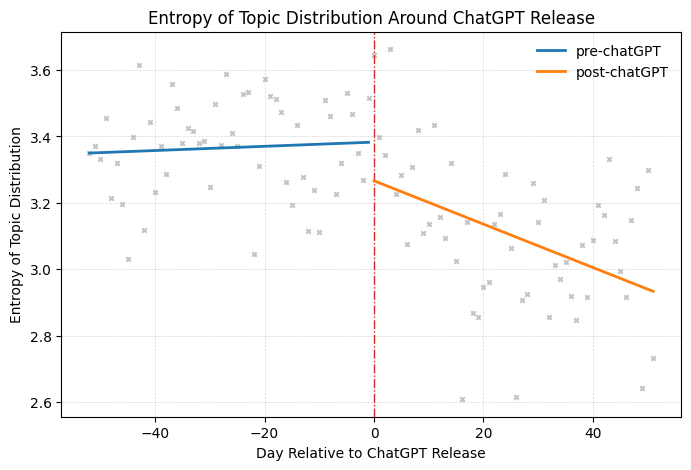

In [37]:
draw_scatter_line_plot(entropy_dict['0'], '0', 'Entropy')

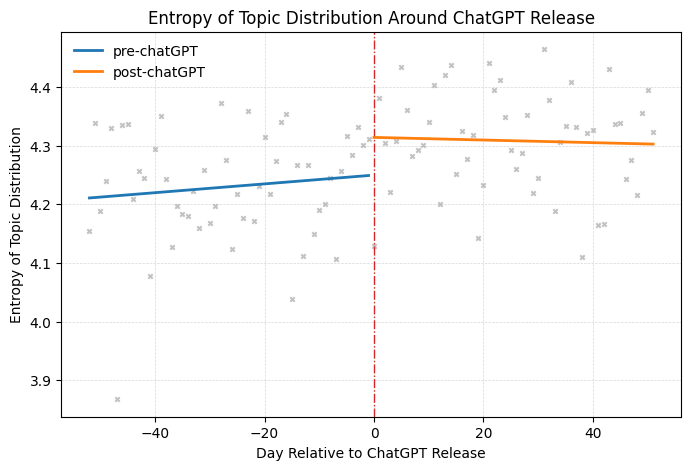

In [38]:
draw_scatter_line_plot(entropy_dict['1'], '1', 'Entropy')

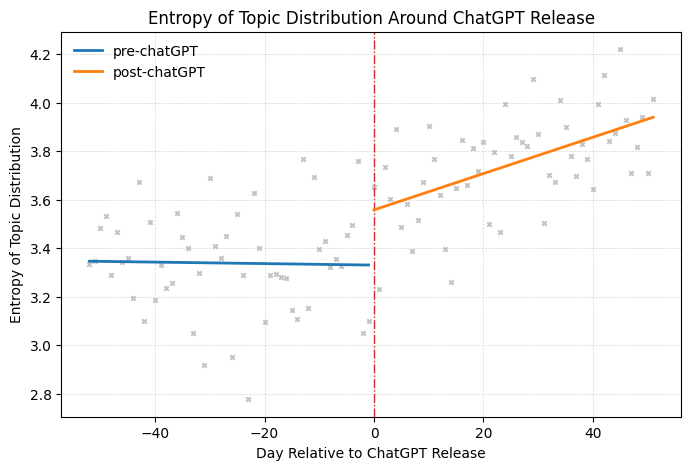

In [39]:
draw_scatter_line_plot(entropy_dict['2'], '', 'Entropy')

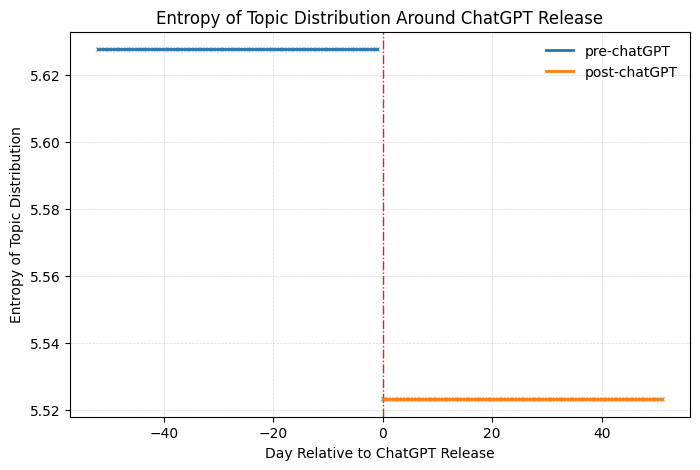

In [40]:
draw_scatter_line_plot(entropy_dict_gpt['0'], '0', 'Entropy')

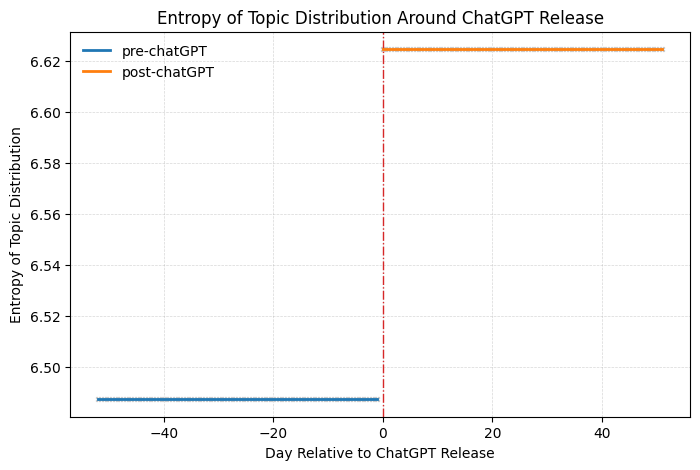

In [41]:
draw_scatter_line_plot(entropy_dict_gpt['1'], '1', 'Entropy')

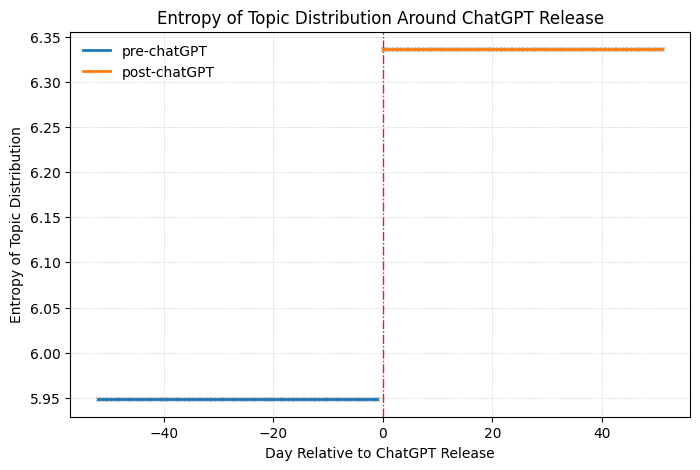

In [42]:
draw_scatter_line_plot(entropy_dict_gpt['2'], '2', 'Entropy')

In [43]:
def calc_entropy_contributions(G):
    degrees = np.array([degree for _, degree in G.degree()])
    degree_sum = degrees.sum()
    p = degrees / degree_sum
    entropy_contributions = - p * np.log(p)
    node_names = [node for node, _ in G.degree()]
    return dict(zip(node_names, entropy_contributions))

In [44]:
def calc_normalized_entropy_contributions(G):
    degrees = np.array([d for _, d in G.degree()])
    degree_sum = degrees.sum()
    p = degrees / degree_sum
    entropy = -np.sum(p * np.log2(p))  # 전체 entropy H

    contributions = -p * np.log2(p)
    normalized_contrib = contributions / entropy  # 정규화

    node_names = [node for node, _ in G.degree()]
    return dict(zip(node_names, normalized_contrib))


In [45]:
def calc_degree_gini(G):
    # 노드 별로 기여도를 알 수가 없음 지니는....어키....
    degrees = np.array([degree for _, degree in G.degree()], dtype=np.float64)
    degrees = degrees.flatten()

    if np.amin(degrees) < 0:
        degrees -= np.amin(degrees)
    degrees += 1e-10  # 0 나눗셈 방지용 작은 값 추가

    degrees = np.sort(degrees)
    n = len(degrees)
    index = np.arange(1, n + 1)

    gini = (np.sum((2 * index - n - 1) * degrees)) / (n * np.sum(degrees))

    node_names = [node for node, _ in G.degree()]
    return dict(zip(node_names,gini))


In [46]:
# 각 네트워크별 계산
def make_diff_df(diff, measure) :
    if measure == 'entropy':
        entropy_contrib_G1 = calc_entropy_contributions(g_yn_dict[diff][0])
        entropy_contrib_G2 = calc_entropy_contributions(g_yn_dict[diff][1])
    elif measure == 'gini':
        entropy_contrib_G1 = calc_degree_gini(g_yn_dict[diff][0])
        entropy_contrib_G2 = calc_degree_gini(g_yn_dict[diff][1])
    else:
        raise ValueError("Invalid measure type. Choose either 'entropy' or 'degree_gini'.")
    
    diff_node = {node: entropy_contrib_G2.get(node, 0) - entropy_contrib_G1.get(node, 0)
        for node in set(list(entropy_contrib_G1.keys()) + list(entropy_contrib_G2.keys()))}
    
    return_ = pd.Series(diff_node).reset_index().rename(columns= {'index' : 'node_name'
                                                    , 0 : 'diff'})
    return_ = return_.sort_values(by = 'diff', ascending=False)
    return return_
    




In [47]:
e_network_f_b = make_diff_df('0', 'entropy')
e_network_f_i = make_diff_df('1', 'entropy')
e_network_f_a = make_diff_df('2', 'entropy')

In [48]:
print(diff)

2


In [49]:
b_dict = dict()
a_dict = dict()
d_dict = dict()
for diff in diff_dict.keys():
    b_dict[diff] = calc_entropy_contributions(g_yn_dict[diff][0])
    a_dict[diff] = calc_entropy_contributions(g_yn_dict[diff][1])

    d_dict[diff] = {node: a_dict[diff].get(node, 0) - b_dict[diff].get(node, 0)
        for node in set(list(b_dict[diff].keys()) + list(a_dict[diff].keys()))}


0
1
2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


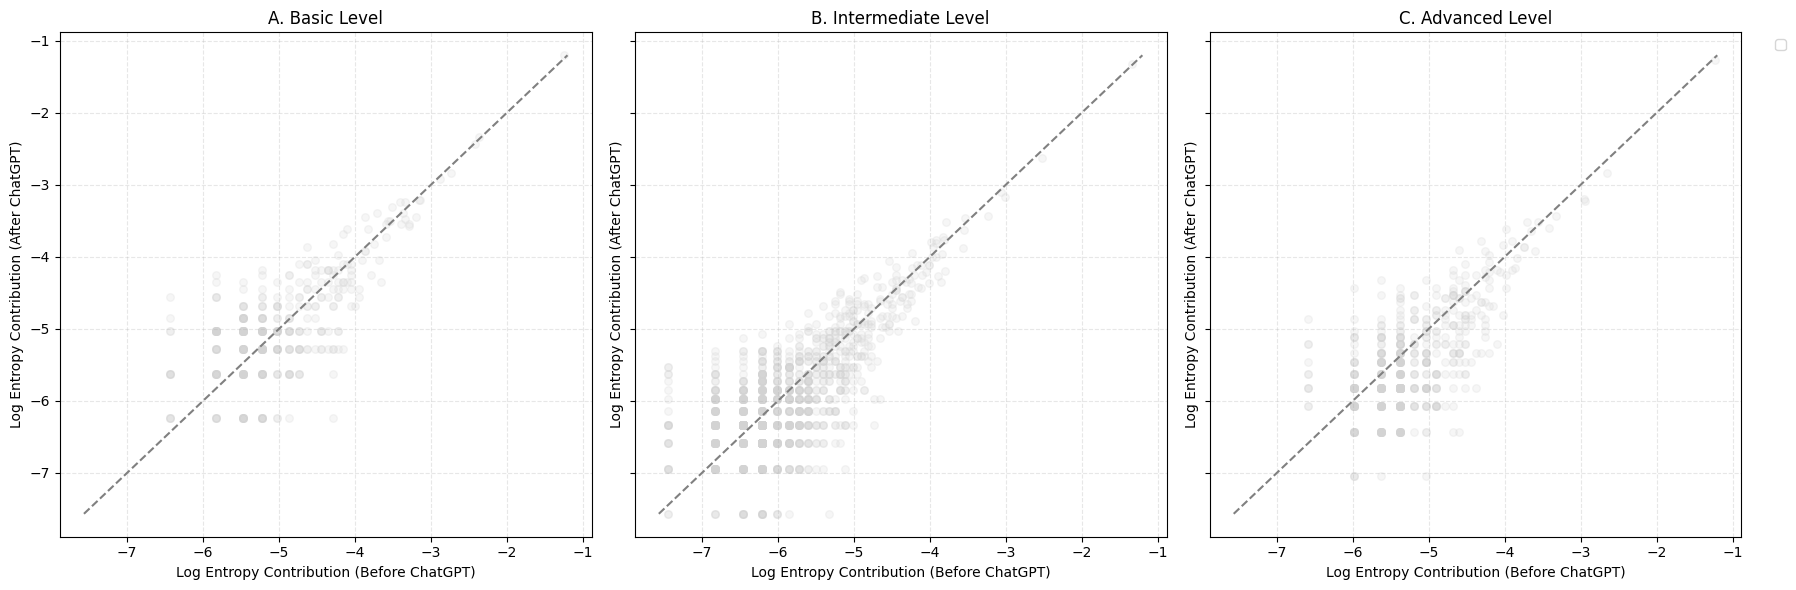

In [50]:
# 시각화 시작
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}
lim_x = []
lim_y = []

for idx, diff in enumerate(diff_dict.keys()):
    print(diff)
    epsilon         = 1e-6
    all_nodes       = list(set(b_dict[diff].keys()).union(a_dict[diff].keys()))
    new_nodes       = set(a_dict[diff].keys()) - set(b_dict[diff].keys())
    disapperaed_nodes = set(b_dict[diff].keys()) - set(a_dict[diff].keys())

    before_vals = [b_dict[diff].get(n, 0) for n in all_nodes]
    after_vals  = [a_dict[diff].get(n, 0) for n in all_nodes]
    diff_vals   = [d_dict[diff].get(n, 0) for n in all_nodes]

    # 로그 변환
    before_log = [np.log(x + epsilon) for x in before_vals]
    after_log  = [np.log(x + epsilon) for x in after_vals]
    
    # Top/Bottom 5 노드
    sorted_nodes = sorted(d_dict[diff].items(), key=lambda x: x[1], reverse=True)
    top_5_nodes = [node for node, _ in sorted_nodes[:5]]
    bottom_5_nodes = [node for node, _ in sorted_nodes[-5:]]
    # 0 파 2 주 4 빨 6 초
    # 라벨 모으기
    texts = []
    for node in all_nodes:
        i = all_nodes.index(node)
        x = before_log[i]
        y = after_log[i]

        if (node not in top_5_nodes) & (node not in bottom_5_nodes) & (node not in new_nodes) & (node not in disapperaed_nodes):
            axs[idx].scatter(x, y, color='lightgray', s=30, alpha = 0.2)
            lim_x.append(x)
            lim_y.append(y)
    # 대각선 기준선

    # 스타일
    axs[idx].set_xlabel('Log Entropy Contribution (Before ChatGPT)')
    axs[idx].set_ylabel('Log Entropy Contribution (After ChatGPT)')
    axs[idx].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
    axs[idx].grid(True, linestyle='--', alpha=0.3)
lims = [min(lim_x + lim_y), max(lim_x + lim_y)]
axs[0].plot(lims, lims, color='gray', linestyle='--')
axs[1].plot(lims, lims, color='gray', linestyle='--')
axs[2].plot(lims, lims, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


0
1
2


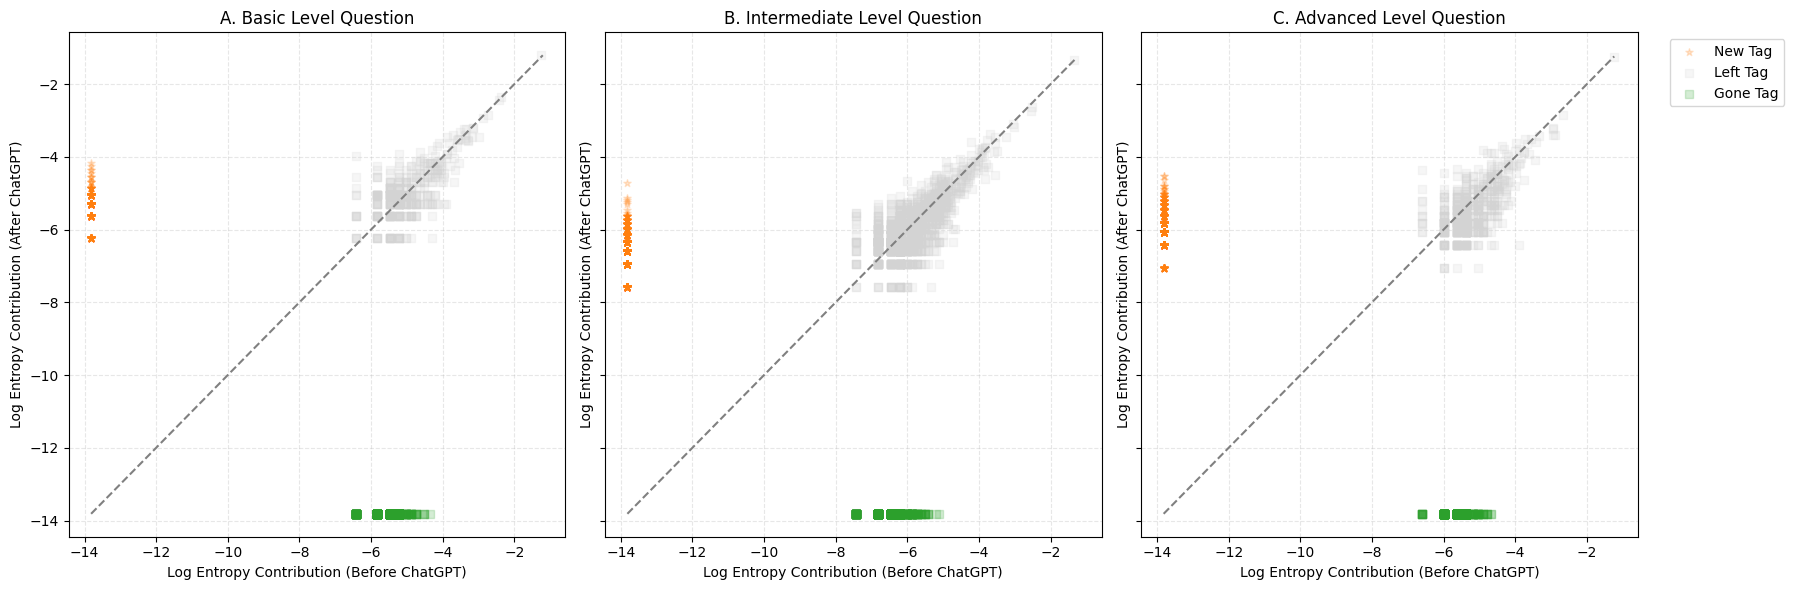

In [51]:
# 시각화 시작
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}
tag_dict = dict()

for idx, diff in enumerate(diff_dict.keys()):
    print(diff)
    epsilon         = 1e-6
    all_nodes       = list(set(b_dict[diff].keys()).union(a_dict[diff].keys()))
    new_nodes       = set(a_dict[diff].keys()) - set(b_dict[diff].keys())
    disapperaed_nodes = set(b_dict[diff].keys()) - set(a_dict[diff].keys())
    left_node = set(b_dict[diff].keys()).union(a_dict[diff].keys()) - (set(a_dict[diff].keys()) - set(b_dict[diff].keys())) - (set(b_dict[diff].keys()) - set(a_dict[diff].keys()))


    tag_dict[diff] = dict()
    tag_dict[diff]['all'] = all_nodes
    tag_dict[diff]['new'] = new_nodes
    tag_dict[diff]['disapperaed'] = disapperaed_nodes


    before_vals = [b_dict[diff].get(n, 0) for n in all_nodes]
    after_vals  = [a_dict[diff].get(n, 0) for n in all_nodes]
    diff_vals   = [d_dict[diff].get(n, 0) for n in all_nodes]

    # 로그 변환
    before_log = [np.log(x + epsilon) for x in before_vals]
    after_log  = [np.log(x + epsilon) for x in after_vals]

    # Top/Bottom 5 노드
    sorted_nodes = sorted(d_dict[diff].items(), key=lambda x: x[1], reverse=True)
    top_5_nodes = [node for node, _ in sorted_nodes[:5]]
    bottom_5_nodes = [node for node, _ in sorted_nodes[-5:]]
    # 0 파 2 주 4 빨 6 초
    # 라벨 모으기
    texts = []
    for n_idx, node in enumerate(all_nodes):
        i = all_nodes.index(node)
        x = before_log[i]
        y = after_log[i]
            
        if node in new_nodes:
            axs[idx].scatter(x, y, color=colors[2], s=30, marker='*', label='New Tag' if node == list(new_nodes)[0] else "", zorder=3, alpha = 0.2)
            # texts.append(plt.text(x, y, f"{node} [NEW]", fontsize=9, color='darkgreen'))
        
        elif node in disapperaed_nodes:
            axs[idx].scatter(x, y, color=colors[4], s=30, marker='s', label='Gone Tag' if node == list(disapperaed_nodes)[0] else "", zorder=3, alpha = 0.2)
            # texts.append(plt.text(x, y, f"{node} [NEW]", fontsize=9, color='darkgreen'))
    
        elif node in left_node:
            axs[idx].scatter(x, y, color='lightgray', s=30, marker='s', label='Left Tag' if node == list(left_node)[0] else "", zorder=2, alpha = 0.2)

    # 자동 라벨 위치 조정
    adjust_text(
    texts,
    ax=axs[idx],
    arrowprops=dict(
        arrowstyle='->', color='gray', lw=0.5,
        shrinkA=0, shrinkB=0
    ),
    force_text=4,
    force_points=3,
    expand_text=(2.5, 2.5),
    expand_points=(2, 2),
    only_move={'points': 'xy', 'text': 'xy'},
    lim=1000
)

    # 대각선 기준선
    lims = [min(before_log + after_log), max(before_log + after_log)]
    axs[idx].plot(lims, lims, color='gray', linestyle='--')

    # 스타일
    axs[idx].set_xlabel('Log Entropy Contribution (Before ChatGPT)')
    axs[idx].set_ylabel('Log Entropy Contribution (After ChatGPT)')
    axs[idx].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level Question')
    axs[idx].grid(True, linestyle='--', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [52]:
basic_gone = ([x for x in b_dict['0'].items() if x[0] in list(tag_dict['0']['disapperaed'])])

# list(tag_dict['0']['disapperaed'] )

In [53]:
basic_gone.sort(key=lambda x: x[1], reverse=True)

In [54]:
basic_gone[:30]

[('object', 0.012748819239649172),
 ('scipy', 0.010769314672476231),
 ('xml-parsing', 0.010769314672476231),
 ('python-3.9', 0.010769314672476231),
 ('ip', 0.008705818978594645),
 ('graph', 0.008705818978594645),
 ('python-module', 0.008705818978594645),
 ('glob', 0.008705818978594645),
 ('element', 0.008705818978594645),
 ('tk-toolkit', 0.008705818978594645),
 ('formatting', 0.007635463401462599),
 ('dynamic', 0.007635463401462599),
 ('iteration', 0.007635463401462599),
 ('nonetype', 0.007635463401462599),
 ('title', 0.007635463401462599),
 ('xml', 0.007635463401462599),
 ('webdriverwait', 0.007635463401462599),
 ('os.path', 0.007635463401462599),
 ('join', 0.007635463401462599),
 ('stack', 0.007635463401462599),
 ('utf-8', 0.0065337272068603435),
 ('kivy-language', 0.0065337272068603435),
 ('key-value', 0.0065337272068603435),
 ('templates', 0.0065337272068603435),
 ('pynput', 0.0065337272068603435),
 ('decimal', 0.0065337272068603435),
 ('neural-network', 0.0065337272068603435),
 ('

0


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


1
2


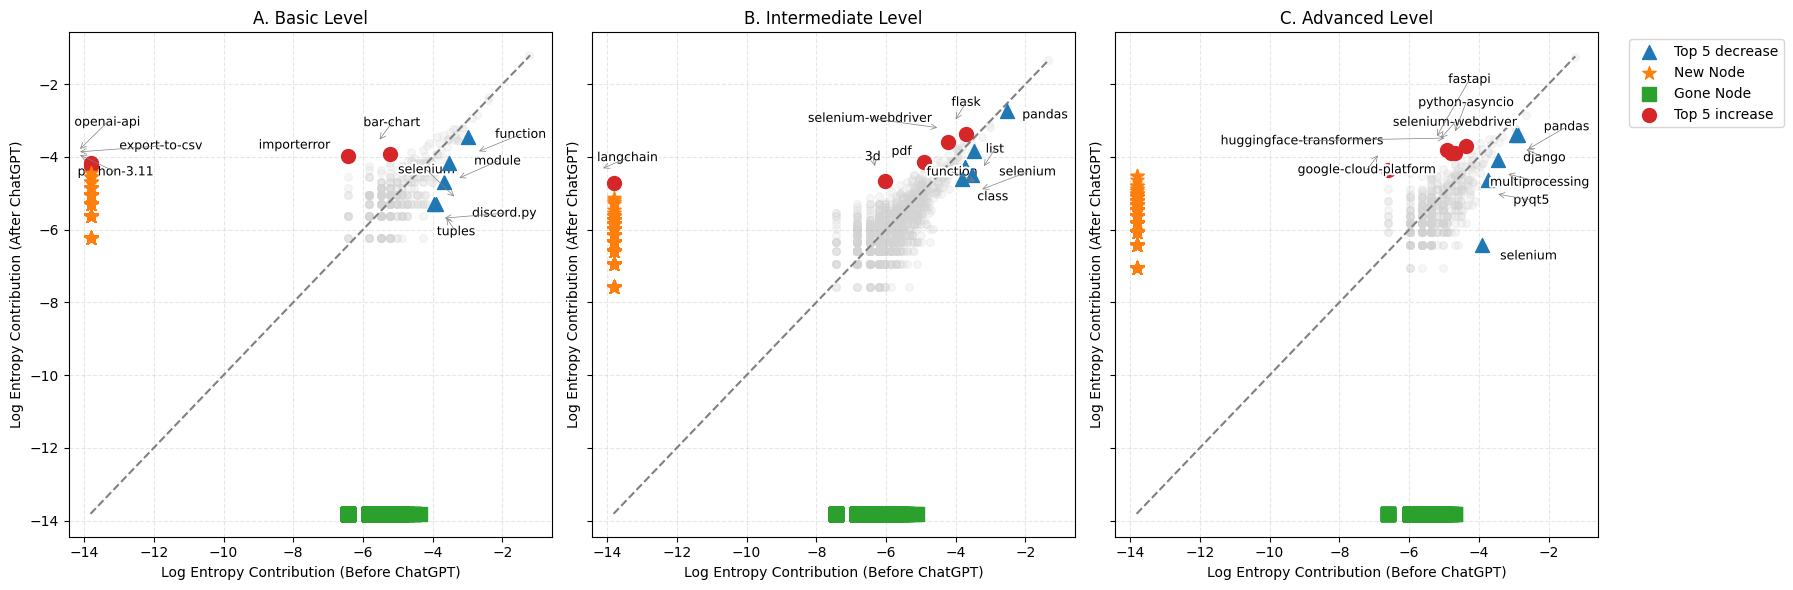

In [55]:
# 시각화 시작
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}

for idx, diff in enumerate(diff_dict.keys()):
    print(diff)
    epsilon         = 1e-6
    all_nodes       = list(set(b_dict[diff].keys()).union(a_dict[diff].keys()))
    new_nodes       = set(a_dict[diff].keys()) - set(b_dict[diff].keys())
    disapperaed_nodes = set(b_dict[diff].keys()) - set(a_dict[diff].keys())

    before_vals = [b_dict[diff].get(n, 0) for n in all_nodes]
    after_vals  = [a_dict[diff].get(n, 0) for n in all_nodes]
    diff_vals   = [d_dict[diff].get(n, 0) for n in all_nodes]

    # 로그 변환
    before_log = [np.log(x + epsilon) for x in before_vals]
    after_log  = [np.log(x + epsilon) for x in after_vals]

    # Top/Bottom 5 노드
    sorted_nodes = sorted(d_dict[diff].items(), key=lambda x: x[1], reverse=True)
    top_5_nodes = [node for node, _ in sorted_nodes[:5]]
    bottom_5_nodes = [node for node, _ in sorted_nodes[-5:]]
    # 0 파 2 주 4 빨 6 초
    # 라벨 모으기
    texts = []
    for node in all_nodes:
        i = all_nodes.index(node)
        x = before_log[i]
        y = after_log[i]
        
        if node in top_5_nodes:
            axs[idx].scatter(x, y, color=colors[6], s=100, marker='o', label='Top 5 increase' if node == top_5_nodes[0] else "", zorder=3)
            texts.append(axs[idx].text(
                                        x - 0.3, y + 0.4, node,
                                        fontsize=9,
                                        color='black',
                                        ha='right',
                                        va='bottom',
                                        path_effects=[pe.withStroke(linewidth=3, foreground='white')]
                )
            )
            
        
        elif node in bottom_5_nodes:
            axs[idx].scatter(x, y, color=colors[0], s=100, marker='^', label='Top 5 decrease' if node == bottom_5_nodes[0] else "", zorder=3)
            texts.append(axs[idx].text(
                                        x + 0.3, y - 0.4, node,
                                        fontsize=9,
                                        color='black',
                                        ha='left',
                                        va='bottom',
                                        path_effects=[pe.withStroke(linewidth=3, foreground='white')]
                )
            )
        
        elif node in new_nodes:
            axs[idx].scatter(x, y, color=colors[2], s=100, marker='*', label='New Node' if node == list(new_nodes)[0] else "", zorder=3)
            # texts.append(plt.text(x, y, f"{node} [NEW]", fontsize=9, color='darkgreen'))
        
        elif node in disapperaed_nodes:
            axs[idx].scatter(x, y, color=colors[4], s=100, marker='s', label='Gone Node' if node == list(disapperaed_nodes)[0] else "", zorder=3)
            # texts.append(plt.text(x, y, f"{node} [NEW]", fontsize=9, color='darkgreen'))
    
        else:
            axs[idx].scatter(x, y, color='lightgray', s=30, alpha = 0.2)

    # 자동 라벨 위치 조정
    adjust_text(
    texts,
    ax=axs[idx],
    arrowprops=dict(
        arrowstyle='->', color='gray', lw=0.5,
        shrinkA=0, shrinkB=0
    ),
    force_text=4,
    force_points=3,
    expand_text=(2.5, 2.5),
    expand_points=(2, 2),
    only_move={'points': 'xy', 'text': 'xy'},
    lim=1000
)

    # 대각선 기준선
    lims = [min(before_log + after_log), max(before_log + after_log)]
    axs[idx].plot(lims, lims, color='gray', linestyle='--')

    # 스타일
    axs[idx].set_xlabel('Log Entropy Contribution (Before ChatGPT)')
    axs[idx].set_ylabel('Log Entropy Contribution (After ChatGPT)')
    axs[idx].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
    axs[idx].grid(True, linestyle='--', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


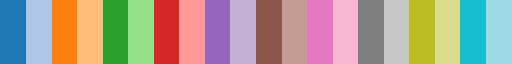

In [56]:
plt.get_cmap('tab20')

In [57]:
top_5_nodes

['fastapi',
 'python-asyncio',
 'selenium-webdriver',
 'google-cloud-platform',
 'huggingface-transformers']

In [58]:
value_dict = dict()

for idx, diff in enumerate(diff_dict.keys()):
    print(diff)
    all_nodes           = len(list(set(b_dict[diff].keys()).union(a_dict[diff].keys())))
    new_nodes           = len(set(a_dict[diff].keys()) - set(b_dict[diff].keys()))
    disapperaed_nodes   = len(set(b_dict[diff].keys()) - set(a_dict[diff].keys()))
    
    new_ratio           = new_nodes/all_nodes
    disapperaed_ratio   = disapperaed_nodes/all_nodes
    remain_ratio        = 1- new_ratio - disapperaed_ratio

    value_dict[diff] = [new_ratio,disapperaed_ratio, remain_ratio]




0
1
2


In [59]:
[value_dict[x][0] for x in diff_dict.keys()]

[0.3100840336134454, 0.3801822993237283, 0.50465914664051]

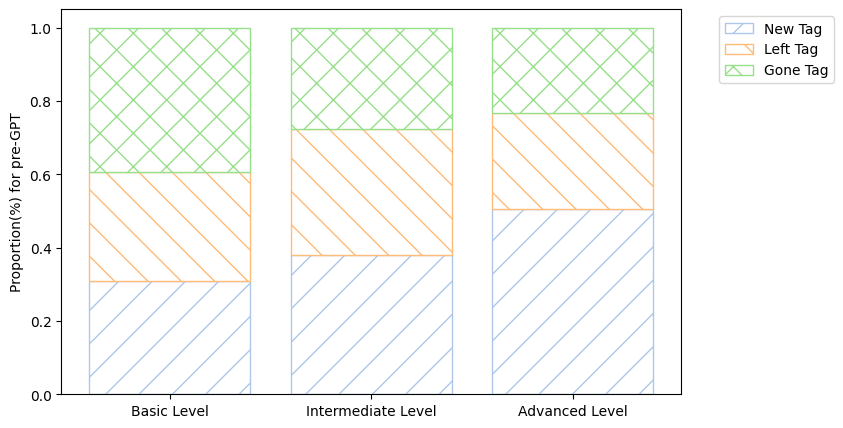

In [ ]:
import matplotlib.pyplot as plt

pallete = sns.color_palette('pastel')
# 데이터 준비
categories = list(diff_dict.keys())  # y축에 표시될 항목
new = [value_dict[x][0] for x in diff_dict.keys()]
gone = [value_dict[x][1] for x in diff_dict.keys()]
left = [value_dict[x][2] for x in diff_dict.keys()]

# 그림 설정
fig, ax = plt.subplots(figsize=(8, 5))

# 첫 번째 바
ax.bar(categories, new, label='New Tag', color='white',edgecolor=colors[1], hatch='/')
# 두 번째 바 (values1 누적 위에 values2를 쌓음)
ax.bar(categories, left, bottom=new, label='Left Tag', color='white',edgecolor=colors[3], hatch='\\')

# 세 번째 바 (values1 + values2 위에 values3를 쌓음)
left_sum = [v1 + v2 for v1, v2 in zip(new, left)]
ax.bar(categories, gone, bottom=left_sum, label='Gone Tag', color='white', edgecolor=colors[5], hatch='x')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f'{x} Level' for x in list(diff_dict.values())])  # 원하는 텍스트로 바꾸기

# 레전드, 축 라벨, 제목
ax.set_ylabel('Proportion(%) for pre-GPT')
# ax2 = ax.twinx()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(f"{output_dir}Result_Fig8.png", dpi=300, bbox_inches='tight')
# 그래프 보여주기
plt.show()


In [61]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from math import log2

# 예시용: 작은 그래프 (실제 분석에서는 G_before, G_after를 받아야 함)
G_before = nx.karate_club_graph()
G_after = G_before.copy()
G_after.remove_edges_from([(0, 1), (0, 2)])  # 변화를 주기 위해 일부 간선 제거

def compute_network_metrics(G):
    degrees = [d for _, d in G.degree()]
    degree_count = Counter(degrees)
    total_nodes = len(G.nodes)

    # 1. Degree Entropy
    p_k = np.array(list(degree_count.values())) / total_nodes
    degree_entropy = -np.sum(p_k * np.log2(p_k))

    # 2. Network Density
    density = nx.density(G)

    # 3. Average Clustering Coefficient
    clustering = nx.average_clustering(G)

    # 4. Modularity (Louvain method is not in networkx, use community_louvain if needed)
    # Placeholder: number of connected components as proxy for community count
    num_components = nx.number_connected_components(G.to_undirected())

    return {
        'degree_entropy': degree_entropy,
        'density': density,
        'avg_clustering': clustering,
        'num_components': num_components
    }

# 계산
metrics_before = compute_network_metrics(G_before)
metrics_after = compute_network_metrics(G_after)

metrics_before, metrics_after


({'degree_entropy': 2.857222096667174,
  'density': 0.13903743315508021,
  'avg_clustering': 0.5706384782076823,
  'num_components': 1},
 {'degree_entropy': 2.857222096667174,
  'density': 0.1354723707664884,
  'avg_clustering': 0.470473283924841,
  'num_components': 1})

In [62]:
# 계산
df = pd.DataFrame()
for diff in diff_dict.keys():
    metrics_before = compute_network_metrics(g_yn_dict[diff][0]) # before
    metrics_after = compute_network_metrics(g_yn_dict[diff][1]) # after
    tmp = pd.DataFrame([metrics_before, metrics_after], index=[f'{diff}_before', f'{diff}_after'])
    df = pd.concat([df, tmp], axis = 0)


In [63]:
df = df.reset_index()

In [64]:
df['diff'] = df['index'].apply(lambda x: diff_dict[x.split('_')[0]])
df['type'] = df['index'].apply(lambda x: x.split('_')[1])

In [65]:
pdf1 = pd.pivot_table(df,                # 피벗할 데이터프레임
                     index = 'diff',    # 행 위치에 들어갈 열
                     columns = 'type',    # 열 위치에 들어갈 열
                     values = ['degree_entropy', 'density', 'avg_clustering']     # 데이터로 사용할 열
                     ).reset_index()   # 데이터 집계함수

In [66]:
pdf1

diff avg_clustering           degree_entropy            \
type                        after    before          after    before   
0         Advanced       0.820788  0.835515       3.203207  3.055934   
1            Basic       0.762356  0.773741       3.189912  3.306346   
2     Intermediate       0.778032  0.787986       3.545373  3.542755   

       density            
type     after    before  
0     0.004341  0.006300  
1     0.008214  0.007926  
2     0.003145  0.003744

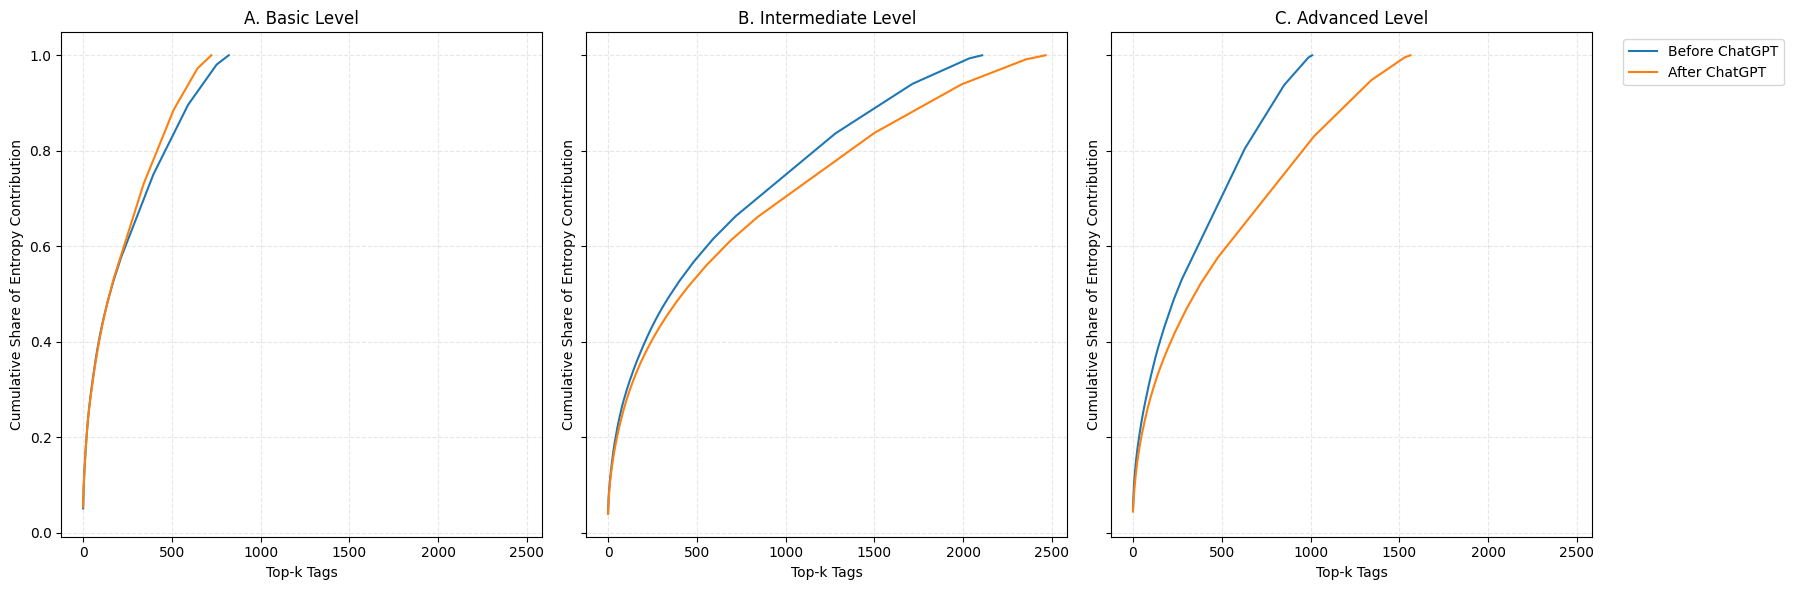

In [67]:
# 시각화 시작
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}

for idx, diff in enumerate(diff_dict.keys()):
    contrib_before = calc_normalized_entropy_contributions(g_yn_dict[diff][0])
    vals = np.array(sorted(contrib_before.values(), reverse=True))
    cumsum = np.cumsum(vals)
    cumsum /= cumsum[-1]  # 정규화 (총합 = 1)
    axs[idx].plot(cumsum, label='Before ChatGPT')

    contrib_after  = calc_normalized_entropy_contributions(g_yn_dict[diff][1])
    vals = np.array(sorted(contrib_after.values(), reverse=True))
    cumsum = np.cumsum(vals)
    cumsum /= cumsum[-1]  # 정규화 (총합 = 1)
    axs[idx].plot(cumsum, label='After ChatGPT')


    # 스타일
    axs[idx].set_xlabel('Top-k Tags')
    axs[idx].set_ylabel('Cumulative Share of Entropy Contribution')
    axs[idx].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
    axs[idx].grid(True, linestyle='--', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()






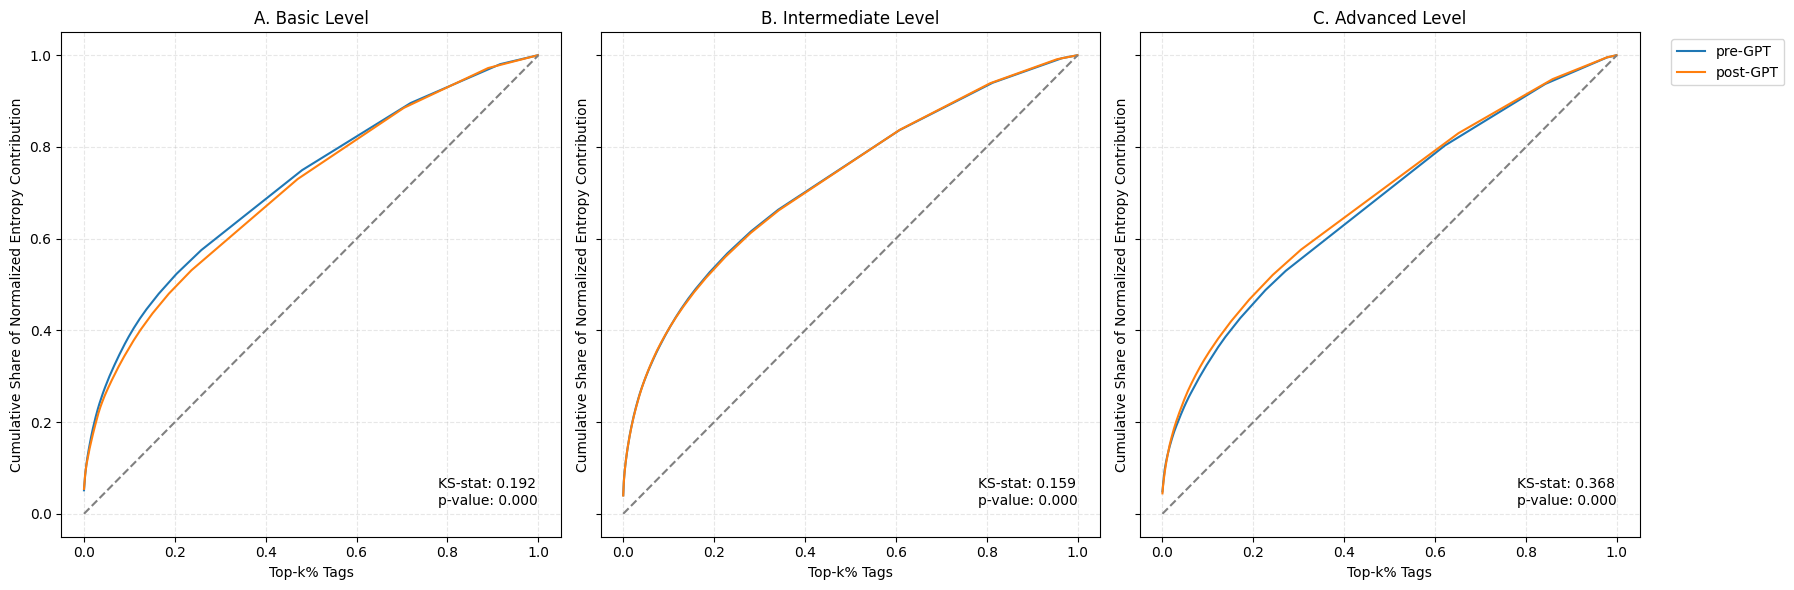

In [68]:
# 시각화 시작
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=False, sharey=True)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}

for idx, diff in enumerate(diff_dict.keys()):
    contrib_before = calc_normalized_entropy_contributions(g_yn_dict[diff][0])
    bf_vals = np.array(sorted(contrib_before.values(), reverse=True))
    bf_cumsum = np.cumsum(bf_vals)
    bf_cumsum /= bf_cumsum[-1]  # 정규화 (총합 = 1)
    bf_x_vals = np.arange(len(bf_cumsum)) / len(bf_cumsum)
    axs[idx].plot(bf_x_vals, bf_cumsum, label='pre-GPT')

    contrib_after  = calc_normalized_entropy_contributions(g_yn_dict[diff][1])
    af_vals = np.array(sorted(contrib_after.values(), reverse=True))
    af_cumsum = np.cumsum(af_vals)
    af_cumsum /= af_cumsum[-1]  # 정규화 (총합 = 1)
    af_x_vals = np.arange(len(af_cumsum)) / len(af_cumsum)
    axs[idx].plot(af_x_vals, af_cumsum, label='post-GPT')

    shared_keys = set(contrib_before) & set(contrib_after)
    before_vec = np.array([contrib_before[k] for k in shared_keys])
    after_vec  = np.array([contrib_after[k]  for k in shared_keys])


    stat, p = ks_2samp(before_vec, after_vec)

    axs[idx].text(0.78, 0.02, f'KS-stat: {stat:.3f}\np-value: {p:.3f}',fontsize=10)

    # 대각선 기준선
    lims = [0, 1]
    axs[idx].plot(lims, lims, color='gray', linestyle='--')


    # 스타일
    axs[idx].set_xlabel('Top-k% Tags')
    axs[idx].set_ylabel('Cumulative Share of Normalized Entropy Contribution')
    axs[idx].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
    axs[idx].grid(True, linestyle='--', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}Result_Fig7.png", dpi=300, bbox_inches='tight')
plt.show()






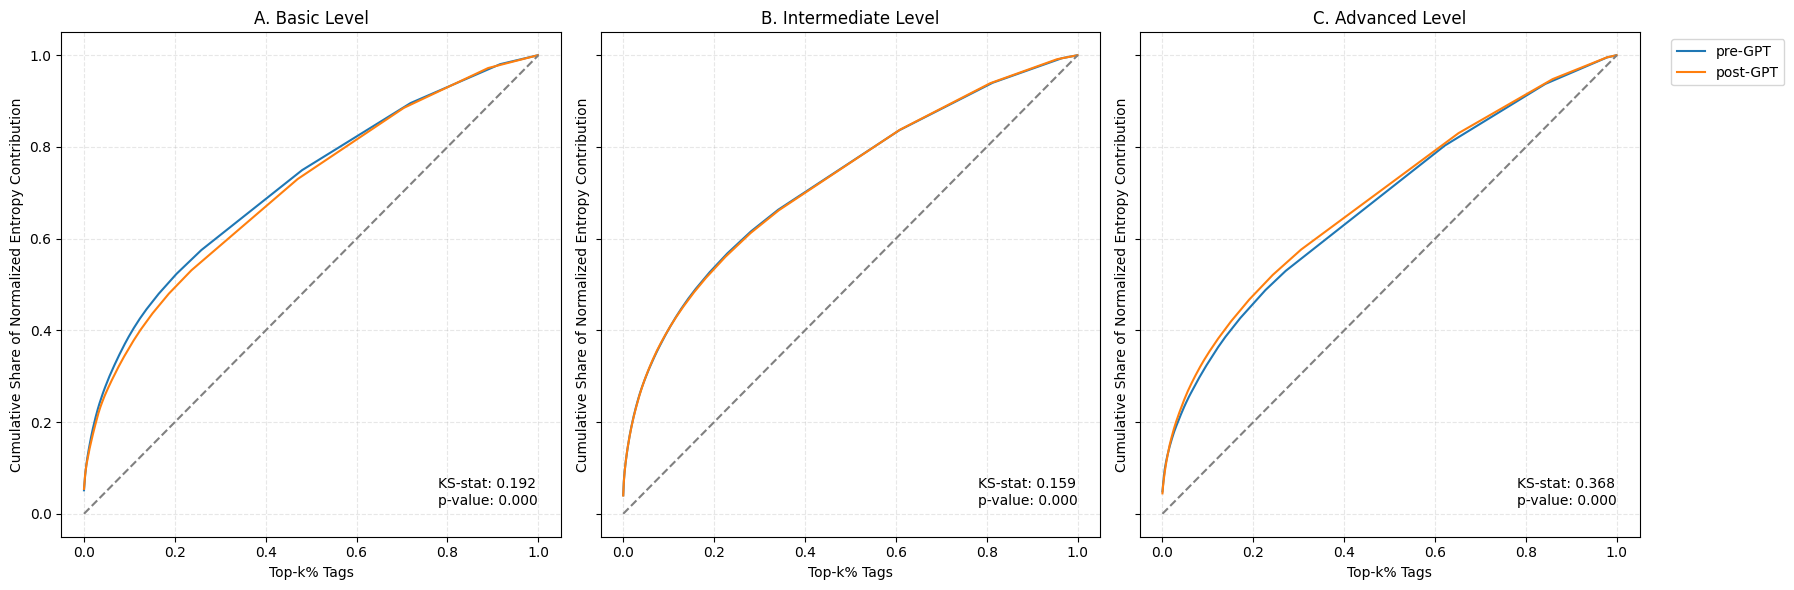

In [69]:
# 시각화 시작
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=False, sharey=True)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}

for idx, diff in enumerate(diff_dict.keys()):
    contrib_before = calc_normalized_entropy_contributions(g_yn_dict[diff][0])
    bf_vals = np.array(sorted(contrib_before.values(), reverse=True))
    bf_cumsum = np.cumsum(bf_vals)
    bf_cumsum /= bf_cumsum[-1]  # 정규화 (총합 = 1)
    bf_x_vals = np.arange(len(bf_cumsum)) / len(bf_cumsum)
    axs[idx].plot(bf_x_vals, bf_cumsum, label='pre-GPT')

    contrib_after  = calc_normalized_entropy_contributions(g_yn_dict[diff][1])
    af_vals = np.array(sorted(contrib_after.values(), reverse=True))
    af_cumsum = np.cumsum(af_vals)
    af_cumsum /= af_cumsum[-1]  # 정규화 (총합 = 1)
    af_x_vals = np.arange(len(af_cumsum)) / len(af_cumsum)
    axs[idx].plot(af_x_vals, af_cumsum, label='post-GPT')

    shared_keys = set(contrib_before) & set(contrib_after)
    before_vec = np.array([contrib_before[k] for k in shared_keys])
    after_vec  = np.array([contrib_after[k]  for k in shared_keys])


    stat, p = ks_2samp(before_vec, after_vec)

    axs[idx].text(0.78, 0.02, f'KS-stat: {stat:.3f}\np-value: {p:.3f}',fontsize=10)

    # 대각선 기준선
    lims = [0, 1]
    axs[idx].plot(lims, lims, color='gray', linestyle='--')


    # 스타일
    axs[idx].set_xlabel('Top-k% Tags')
    axs[idx].set_ylabel('Cumulative Share of Normalized Entropy Contribution')
    axs[idx].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
    axs[idx].grid(True, linestyle='--', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}Result_Fig7.png", dpi=300, bbox_inches='tight')
plt.show()






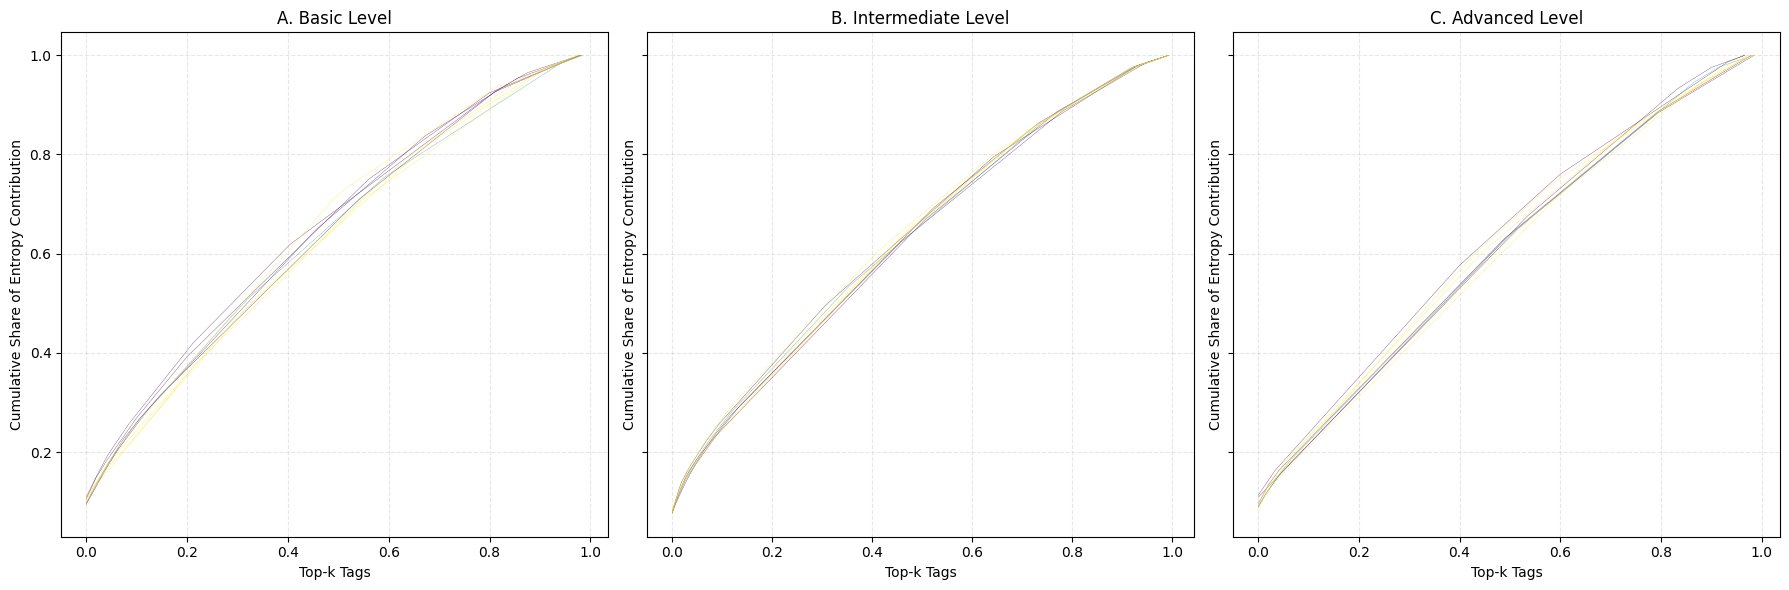

In [70]:
# 시각화 시작
import matplotlib
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=False, sharey=True)
weeks = 20  # e.g. list of weekly cumulative curves
cmap = matplotlib.colormaps['viridis']
week_range = np.arange(-5, 5, 1)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}

for idx, diff in enumerate(diff_dict.keys()):
    weeks_sorted = sorted(g_week_dict[diff].keys())
    
    for week_idx, week in enumerate(weeks_sorted):

        if (week > -5) and (week < 5) :
            contrib_before = calc_entropy_contributions(g_week_dict[diff][week])
            vals = np.array(sorted(contrib_before.values(), reverse=True))
            cumsum = np.cumsum(vals)
            cumsum /= cumsum[-1]
            x_vals = np.arange(len(cumsum)) / len(cumsum)
            color = cmap(week+5 / (len(week_range) - 1)) 
            axs[idx].plot(x_vals,  cumsum, color=color, linewidth=0.2)
            axs[idx].set_xlabel('Top-k Tags')
            axs[idx].set_ylabel('Cumulative Share of Entropy Contribution')
            axs[idx].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
            axs[idx].grid(True, linestyle='--', alpha=0.3)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()






In [71]:
import networkx as nx
import matplotlib.pyplot as plt

def build_tag_network(tag_cooccurrence_dict, tag_status_dict):
    G = nx.Graph()
    
    # 노드 추가
    for tag, status in tag_status_dict.items():
        G.add_node(tag, status=status)
    
    # 엣지 추가
    for (tag1, tag2), weight in tag_cooccurrence_dict.items():
        if tag1 in G.nodes and tag2 in G.nodes:
            G.add_edge(tag1, tag2, weight=weight)
    
    return G

def draw_tag_network(G):
    pos = nx.spring_layout(G, seed=42)

    # 상태별 노드 색상 설정
    color_map = {
        'new': 'blue',
        'gone': 'orange',
        'left': 'gray'
    }
    node_colors = [color_map[G.nodes[n]['status']] for n in G.nodes]

    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color='lightgray', font_size=8)
    plt.title("Tag Network: New / Gone / Left After GPT")
    plt.show()


In [72]:
# tag_status_dict = {
#     'python-3.11': 'new',
#     'openai-api': 'new',
#     'tkinter': 'gone',
#     'django': 'left',
#     ...
# }

# tag_cooccurrence_dict = {
#     ('openai-api', 'python'): 32,
#     ('tkinter', 'gui'): 15,
#     ('django', 'rest'): 40,
#     ...
# }


In [73]:
for idx, diff in enumerate(diff_dict.keys()):
    print(diff)
    epsilon         = 1e-6
    all_nodes       = list(set(b_dict[diff].keys()).union(a_dict[diff].keys()))
    new_nodes       = set(a_dict[diff].keys()) - set(b_dict[diff].keys())
    disapperaed_nodes = set(b_dict[diff].keys()) - set(a_dict[diff].keys())
    pd.DataFrame([ {'Id':x, 'Label' : x, 'Status' : 'new' if x in new_nodes else ('gone' if x in disapperaed_nodes else 'left')
} for x in all_nodes ]).to_csv(f'./nodes_{diff}.csv', index=False)

0
1
2


In [74]:
for idx, diff in enumerate(diff_dict.keys()):
    print(diff)
    tmp_df = tot_t_list[tot_t_list['difficulty'] == diff]
    tmp_diff_df = tmp_df.groupby(['tag_from', 'tag_to'])['id'].count().reset_index(name='Weight').sort_values(['Weight'], ascending=False).reset_index(drop=True)
    tmp_diff_df.rename(columns = {'tag_from' : 'Source', 'tag_to' : 'Target'}, inplace=True)
    tmp_diff_df.to_csv(f'./edges_{diff}.csv', index=False)
    


0
1
2


In [75]:
tmp_diff_df

,Source,Target,Weight
0,python,tensorflow,150
1,tensorflow,python,150
2,python,python-3.x,149
3,python-3.x,python,149
4,python,pandas,115
...,...,...,...
15249,kernel-density,matplotlib,1
15250,kernel-density,numpy,1
15251,kernel-density,python,1
15252,kernel-density,seaborn,1


In [76]:
g_dict = dict()
for diff in diff_dict.keys():
    g_dict[diff] = dict()
    tmp = tot_t_list[tot_t_list['difficulty'] == diff]
    g_dict[diff] = make_network([x for x in tmp['tags_for_n']])
        

In [77]:
tag_dict['0']['new']

{'aggregate',
 'alpha-vantage',
 'amazon-athena',
 'anaconda3',
 'any',
 'apache-spark-sql',
 'appium',
 'artificial-intelligence',
 'ascii-art',
 'assign',
 'asynchronous',
 'attachment',
 'audio',
 'audiosegment',
 'auto-py-to-exe',
 'autopy',
 'axis',
 'azure',
 'azure-blob-storage',
 'batch-file',
 'bdd',
 'beeware',
 'bin',
 'binary-search',
 'bioinformatics',
 'boolean-expression',
 'boolean-logic',
 'built-in-types',
 'case-insensitive',
 'case-sensitive',
 'cassandra',
 'casting',
 'charts',
 'chat-gpt-4',
 'chatgpt-api',
 'chatgpt-plugin',
 'chess',
 'circos',
 'classification',
 'click',
 'clickhouse',
 'client-library',
 'clock',
 'cloud',
 'code-inspection',
 'command',
 'command-line',
 'command-line-interface',
 'comments',
 'compare',
 'compiler-errors',
 'compression',
 'config',
 'confusion-matrix',
 'console',
 'constants',
 'copybook',
 'correlation',
 'counting',
 'cplex',
 'cpu-usage',
 'cql',
 'crm',
 'cryptography',
 'csvkit',
 'curl',
 'customtkinter',
 'cyber-a

In [78]:
new_nodes       = set(a_dict[diff].keys()) - set(b_dict[diff].keys())

In [79]:
basic_gone = ([x for x in b_dict['0'].items() if x[0] in list(tag_dict['0']['disapperaed'])])
inter_gone = ([x for x in b_dict['1'].items() if x[0] in list(tag_dict['1']['disapperaed'])])
advan_gone = ([x for x in b_dict['2'].items() if x[0] in list(tag_dict['2']['disapperaed'])])

basic_gone.sort(key=lambda x: x[1], reverse=True)
inter_gone.sort(key=lambda x: x[1], reverse=True)
advan_gone.sort(key=lambda x: x[1], reverse=True)


# list(tag_dict['0']['disapperaed'] )

In [80]:
basic_new = ([x for x in a_dict['0'].items() if x[0] in list(tag_dict['0']['new'])])
inter_new = ([x for x in a_dict['1'].items() if x[0] in list(tag_dict['1']['new'])])
advan_new = ([x for x in a_dict['2'].items() if x[0] in list(tag_dict['2']['new'])])

basic_new.sort(key=lambda x: x[1], reverse=True)
inter_new.sort(key=lambda x: x[1], reverse=True)
advan_new.sort(key=lambda x: x[1], reverse=True)

# list(tag_dict['0']['disapperaed'] )

In [81]:
basic_gone.sort(key=lambda x: x[1], reverse=True)

In [82]:
basic_gone[:30]

[('object', 0.012748819239649172),
 ('scipy', 0.010769314672476231),
 ('xml-parsing', 0.010769314672476231),
 ('python-3.9', 0.010769314672476231),
 ('ip', 0.008705818978594645),
 ('graph', 0.008705818978594645),
 ('python-module', 0.008705818978594645),
 ('glob', 0.008705818978594645),
 ('element', 0.008705818978594645),
 ('tk-toolkit', 0.008705818978594645),
 ('formatting', 0.007635463401462599),
 ('dynamic', 0.007635463401462599),
 ('iteration', 0.007635463401462599),
 ('nonetype', 0.007635463401462599),
 ('title', 0.007635463401462599),
 ('xml', 0.007635463401462599),
 ('webdriverwait', 0.007635463401462599),
 ('os.path', 0.007635463401462599),
 ('join', 0.007635463401462599),
 ('stack', 0.007635463401462599),
 ('utf-8', 0.0065337272068603435),
 ('kivy-language', 0.0065337272068603435),
 ('key-value', 0.0065337272068603435),
 ('templates', 0.0065337272068603435),
 ('pynput', 0.0065337272068603435),
 ('decimal', 0.0065337272068603435),
 ('neural-network', 0.0065337272068603435),
 ('

In [83]:
basic_entropy_contrib_G0 = calc_entropy_contributions(g_yn_dict['0'][0])
inter_entropy_contrib_G0 = calc_entropy_contributions(g_yn_dict['1'][0])
advan_entropy_contrib_G0 = calc_entropy_contributions(g_yn_dict['2'][0])


basic_entropy_contrib_G1 = calc_entropy_contributions(g_yn_dict['0'][1])
inter_entropy_contrib_G1 = calc_entropy_contributions(g_yn_dict['1'][1])
advan_entropy_contrib_G1 = calc_entropy_contributions(g_yn_dict['2'][1])





In [84]:
g_yn_dict['0'][0]

In [85]:
basic_t_list0 = tot_t_list[(tot_t_list['difficulty'] =='0') & (tot_t_list['gpt_yn'] ==0)]
inter_t_list0 = tot_t_list[(tot_t_list['difficulty'] =='1') & (tot_t_list['gpt_yn'] ==0)]
advan_t_list0 = tot_t_list[(tot_t_list['difficulty'] =='2') & (tot_t_list['gpt_yn'] ==0)]


In [86]:
basic_t_list1 = tot_t_list[(tot_t_list['difficulty'] =='0') & (tot_t_list['gpt_yn'] ==1)]
inter_t_list1 = tot_t_list[(tot_t_list['difficulty'] =='1') & (tot_t_list['gpt_yn'] ==1)]
advan_t_list1 = tot_t_list[(tot_t_list['difficulty'] =='2') & (tot_t_list['gpt_yn'] ==1)]


In [87]:
b_tag0 = pd.concat([basic_t_list0['tag_from'],
                    basic_t_list0['tag_to']], axis = 0).reset_index(drop=True).reset_index().rename(columns = { 0 : 'tag'})
i_tag0 = pd.concat([inter_t_list0['tag_from'],
                    inter_t_list0['tag_to']], axis = 0).reset_index(drop=True).reset_index().rename(columns = { 0 : 'tag'})
a_tag0 = pd.concat([advan_t_list0['tag_from'],
                    advan_t_list0['tag_to']], axis = 0).reset_index(drop=True).reset_index().rename(columns = { 0 : 'tag'})

In [88]:
b_tag1 = pd.concat([basic_t_list1['tag_from'],
                    basic_t_list1['tag_to']], axis = 0).reset_index(drop=True).reset_index().rename(columns = { 0 : 'tag'})
i_tag1 = pd.concat([inter_t_list1['tag_from'],
                    inter_t_list1['tag_to']], axis = 0).reset_index(drop=True).reset_index().rename(columns = { 0 : 'tag'})
a_tag1 = pd.concat([advan_t_list1['tag_from'],
                    advan_t_list1['tag_to']], axis = 0).reset_index(drop=True).reset_index().rename(columns = { 0 : 'tag'})

In [89]:
b_tag0 = b_tag0.groupby(['tag'])['index'].count().reset_index().rename(columns = {'index' : 'count'}).sort_values(by = 'count', ascending=False).reset_index(drop=True)
i_tag0 = i_tag0.groupby(['tag'])['index'].count().reset_index().rename(columns = {'index' : 'count'}).sort_values(by = 'count', ascending=False).reset_index(drop=True)
a_tag0 = a_tag0.groupby(['tag'])['index'].count().reset_index().rename(columns = {'index' : 'count'}).sort_values(by = 'count', ascending=False).reset_index(drop=True)

In [90]:
b_tag1 = b_tag1.groupby(['tag'])['index'].count().reset_index().rename(columns = {'index' : 'count'}).sort_values(by = 'count', ascending=False).reset_index(drop=True)
i_tag1 = i_tag1.groupby(['tag'])['index'].count().reset_index().rename(columns = {'index' : 'count'}).sort_values(by = 'count', ascending=False).reset_index(drop=True)
a_tag1 = a_tag1.groupby(['tag'])['index'].count().reset_index().rename(columns = {'index' : 'count'}).sort_values(by = 'count', ascending=False).reset_index(drop=True)

In [91]:
basic_en_df0 = pd.DataFrame({'tag' : list(basic_entropy_contrib_G0.keys())
              ,'entropy': list(basic_entropy_contrib_G0.values())})
inter_en_df0 = pd.DataFrame({'tag' : list(inter_entropy_contrib_G0.keys())
              ,'entropy': list(inter_entropy_contrib_G0.values())})
advan_en_df0 = pd.DataFrame({'tag' : list(advan_entropy_contrib_G0.keys())
              ,'entropy': list(advan_entropy_contrib_G0.values())})

In [92]:
basic_en_df1 = pd.DataFrame({'tag' : list(basic_entropy_contrib_G1.keys())
              ,'entropy': list(basic_entropy_contrib_G1.values())})
inter_en_df1 = pd.DataFrame({'tag' : list(inter_entropy_contrib_G1.keys())
              ,'entropy': list(inter_entropy_contrib_G1.values())})
advan_en_df1 = pd.DataFrame({'tag' : list(advan_entropy_contrib_G1.keys())
              ,'entropy': list(advan_entropy_contrib_G1.values())})

In [93]:
b_viz0 = pd.merge(b_tag0, basic_en_df0, on = 'tag')
i_viz0 = pd.merge(i_tag0, inter_en_df0, on = 'tag')
a_viz0 = pd.merge(a_tag0, advan_en_df0, on = 'tag')

In [94]:
b_viz1 = pd.merge(b_tag1, basic_en_df1, on = 'tag')
i_viz1 = pd.merge(i_tag1, inter_en_df1, on = 'tag')
a_viz1 = pd.merge(a_tag1, advan_en_df1, on = 'tag')

In [95]:
g_b_viz_tmp = b_viz0[b_viz0['tag'].isin([x[0] for x in basic_gone])].reset_index(drop=True)
g_b_viz_tmp['diff'] = 'Basic'
g_i_viz_tmp = i_viz0[i_viz0['tag'].isin([x[0] for x in inter_gone])].reset_index(drop=True)
g_i_viz_tmp['diff'] = 'Intermediate'
g_a_viz_tmp = a_viz0[a_viz0['tag'].isin([x[0] for x in advan_gone])].reset_index(drop=True)
g_a_viz_tmp['diff'] = 'Advanced'

In [96]:
n_b_viz_tmp = b_viz1[b_viz1['tag'].isin([x[0] for x in basic_new])].reset_index(drop=True)
n_b_viz_tmp['diff'] = 'Basic'
n_i_viz_tmp = i_viz1[i_viz1['tag'].isin([x[0] for x in inter_new])].reset_index(drop=True)
n_i_viz_tmp['diff'] = 'Intermediate'
n_a_viz_tmp = a_viz1[a_viz1['tag'].isin([x[0] for x in advan_new])].reset_index(drop=True)
n_a_viz_tmp['diff'] = 'Advanced'

In [97]:
basic_new

[('openai-api', 0.01530375110295591),
 ('export-to-csv', 0.014134772877230858),
 ('post', 0.01294243473151347),
 ('python-3.11', 0.01294243473151347),
 ('command', 0.011724130897520153),
 ('jquery', 0.010476599551275017),
 ('command-line', 0.010476599551275017),
 ('match', 0.010476599551275017),
 ('nested-loops', 0.009195638386458838),
 ('frontend', 0.009195638386458838),
 ('readfile', 0.009195638386458838),
 ('file-not-found', 0.009195638386458838),
 ('timestamp', 0.007875627087589246),
 ('shell', 0.007875627087589246),
 ('config', 0.007875627087589246),
 ('k-means', 0.007875627087589246),
 ('ide', 0.007875627087589246),
 ('thonny', 0.007875627087589246),
 ('localhost', 0.007875627087589246),
 ('pyinstaller', 0.007875627087589246),
 ('powershell', 0.007875627087589246),
 ('windows-10', 0.007875627087589246),
 ('virtualenvwrapper', 0.007875627087589246),
 ('chatgpt-api', 0.007875627087589246),
 ('security', 0.007875627087589246),
 ('delta-live-tables', 0.00650865796793913),
 ('tensor',

In [98]:
g_viz = pd.concat([g_b_viz_tmp, g_i_viz_tmp, g_a_viz_tmp], axis = 0).reset_index(drop=True)

In [99]:
n_viz = pd.concat([n_b_viz_tmp, n_i_viz_tmp, n_a_viz_tmp], axis = 0).reset_index(drop=True)

In [100]:
n_viz

,tag,count,entropy,diff
0,openai-api,32,0.015304,Basic
1,export-to-csv,30,0.014135,Basic
2,python-3.11,22,0.012942,Basic
3,post,22,0.012942,Basic
4,command,20,0.011724,Basic
...,...,...,...,...
2686,instrumentation,2,0.000874,Advanced
2687,google-apps-script,2,0.000874,Advanced
2688,graphviz,2,0.000874,Advanced
2689,treesitter,2,0.000874,Advanced


In [101]:
g_viz['x'] = g_viz['count'].apply(lambda x: np.log(x + 1e-6))
g_viz['y'] = g_viz['entropy'].apply(lambda x: np.log(x + 1e-6))
n_viz['x'] = n_viz['count'].apply(lambda x: np.log(x + 1e-6))
n_viz['y'] = n_viz['entropy'].apply(lambda x: np.log(x + 1e-6))

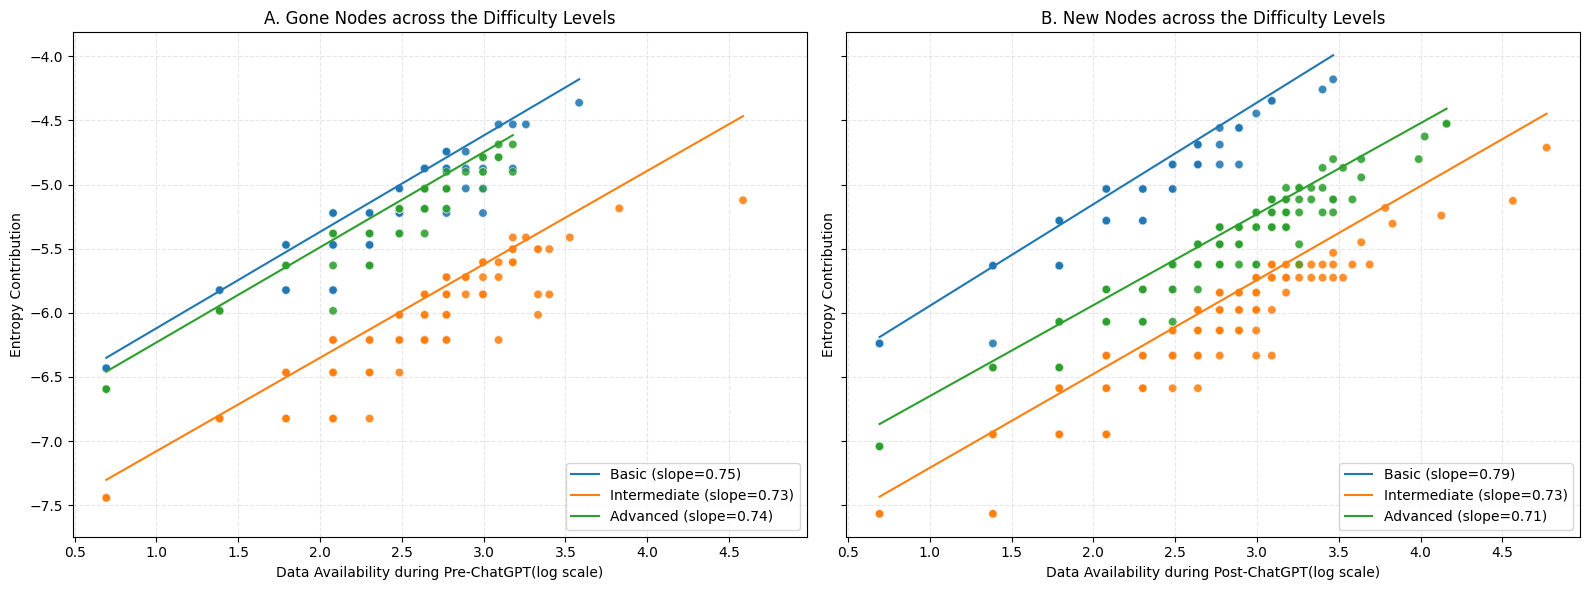

In [102]:
import numpy as np
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots(1, 2 , figsize=(16, 6), sharex=True, sharey=True)

level_order = ['Basic', 'Intermediate', 'Advanced']
color_map = dict(zip(level_order, (colors[0], colors[2], colors[4])))

# 예: 그룹별로 회귀 모델 피팅
for diff in diff_dict.keys():
    # diff에 해당하는 데이터프레임을 가져옴
    group_df = g_viz[g_viz['diff'] == diff_dict[diff]]
    
    # x, y 값 추출
    X = group_df['x'].values.reshape(-1, 1)
    y = group_df['y'].values
    
    # 회귀 모델 피팅
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    # 회귀선 그리기
    x_vals = np.linspace(X.min(), X.max(), 100)
    y_vals = model.predict(x_vals.reshape(-1, 1))
    
    axs[0].plot(x_vals, y_vals, label=f'{diff_dict[diff]} (slope={slope:.2f})', color=color_map[diff_dict[diff]])
    axs[0].set_xlabel('Data Availability during Pre-ChatGPT(log scale)')
    axs[0].set_ylabel('Entropy Contribution')
    axs[0].set_title(f'A. Gone Nodes across the Difficulty Levels')
    axs[0].grid(True, linestyle='--', alpha=0.3)
    axs[0].legend(loc='lower right')
    sns.scatterplot(data=g_viz, x='x', y='y', hue='diff', palette=color_map, legend=False, ax=axs[0], alpha =0.5)

# 예: 그룹별로 회귀 모델 피팅
for diff in diff_dict.keys():
    # diff에 해당하는 데이터프레임을 가져옴
    group_df = n_viz[n_viz['diff'] == diff_dict[diff]]
    
    # x, y 값 추출
    X = group_df['x'].values.reshape(-1, 1)
    y = group_df['y'].values
    
    # 회귀 모델 피팅
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    # 회귀선 그리기
    x_vals = np.linspace(X.min(), X.max(), 100)
    y_vals = model.predict(x_vals.reshape(-1, 1))
    
    axs[1].plot(x_vals, y_vals, label=f'{diff_dict[diff]} (slope={slope:.2f})', color=color_map[diff_dict[diff]])
    axs[1].set_xlabel('Data Availability during Post-ChatGPT(log scale)')
    axs[1].set_ylabel('Entropy Contribution')
    axs[1].set_title(f'B. New Nodes across the Difficulty Levels')
    axs[1].grid(True, linestyle='--', alpha=0.3)
    axs[1].legend(loc='lower right')
    sns.scatterplot(data=n_viz, x='x', y='y', hue='diff', palette=color_map, legend=False, ax=axs[1], alpha = 0.5)
# 산점도도 함께

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [103]:
n_viz.head()

,tag,count,entropy,diff,x,y
0,openai-api,32,0.015304,Basic,3.465736,-4.179592
1,export-to-csv,30,0.014135,Basic,3.401197,-4.259047
2,python-3.11,22,0.012942,Basic,3.091042,-4.347167
3,post,22,0.012942,Basic,3.091042,-4.347167
4,command,20,0.011724,Basic,2.995732,-4.446021


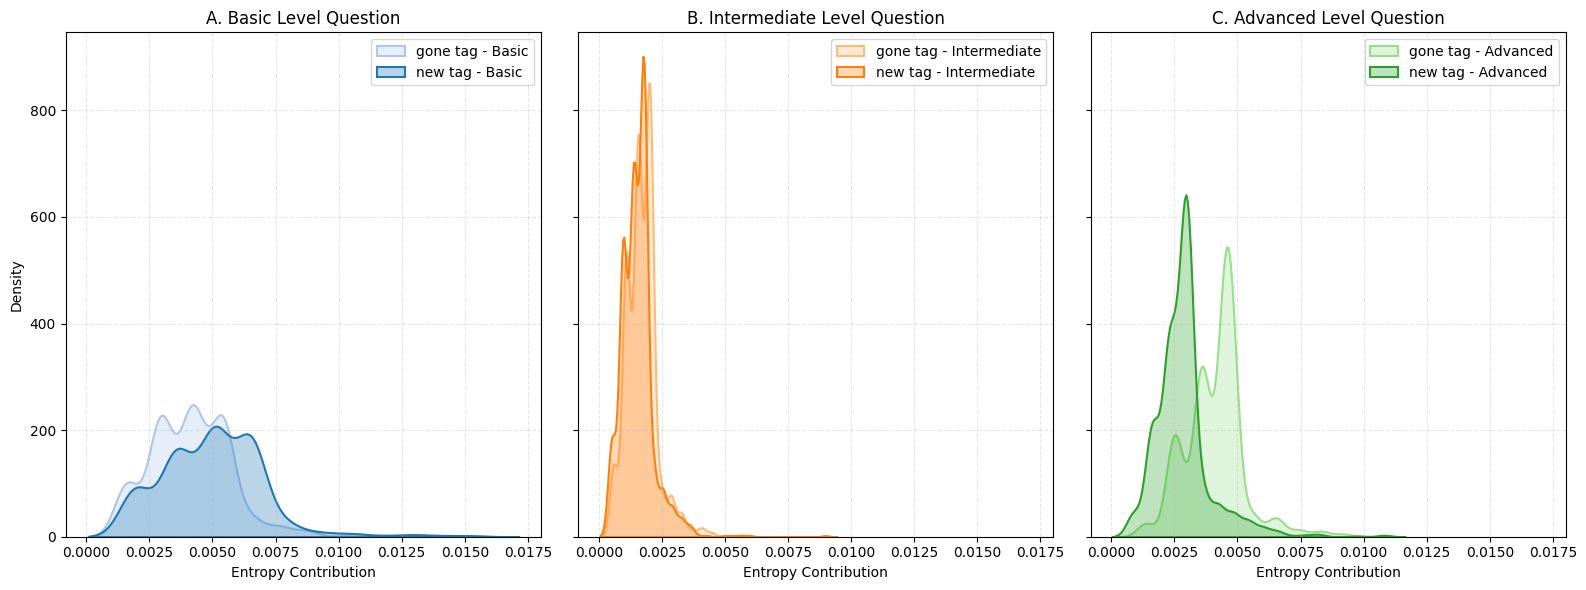

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3 , figsize=(16, 6), sharex=True, sharey=True)
alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}
level_order = ['Basic', 'Intermediate', 'Advanced']
color_map = dict(zip(level_order, (colors[0], colors[2], colors[4])))
color_map2 = dict(zip(level_order, (colors[1], colors[3], colors[5])))

# 예: 그룹별로 회귀 모델 피팅
for idx, diff in enumerate(diff_dict.keys()):
    n_for_loop = n_viz[n_viz['diff'] == diff_dict[diff]]
    g_for_loop = g_viz[g_viz['diff'] == diff_dict[diff]]

    sns.kdeplot(data=g_for_loop, x='entropy', 
                fill=True, alpha=0.3, linewidth=1.5, label=f'gone tag - {diff_dict[diff]}',
                color = color_map2[diff_dict[diff]], ax = axs[idx])
    sns.kdeplot(data=n_for_loop, x='entropy', 
                fill=True, alpha=0.3, linewidth=1.5, label=f'new tag - {diff_dict[diff]}', 
                color = color_map[diff_dict[diff]], ax = axs[idx])

    axs[idx].set_title(f"{alpha_dict[diff]}{level_order[idx]} Level Question")
    axs[idx].set_xlabel("Entropy Contribution")
    axs[idx].set_ylabel("Density")
    axs[idx].legend()
    axs[idx].grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


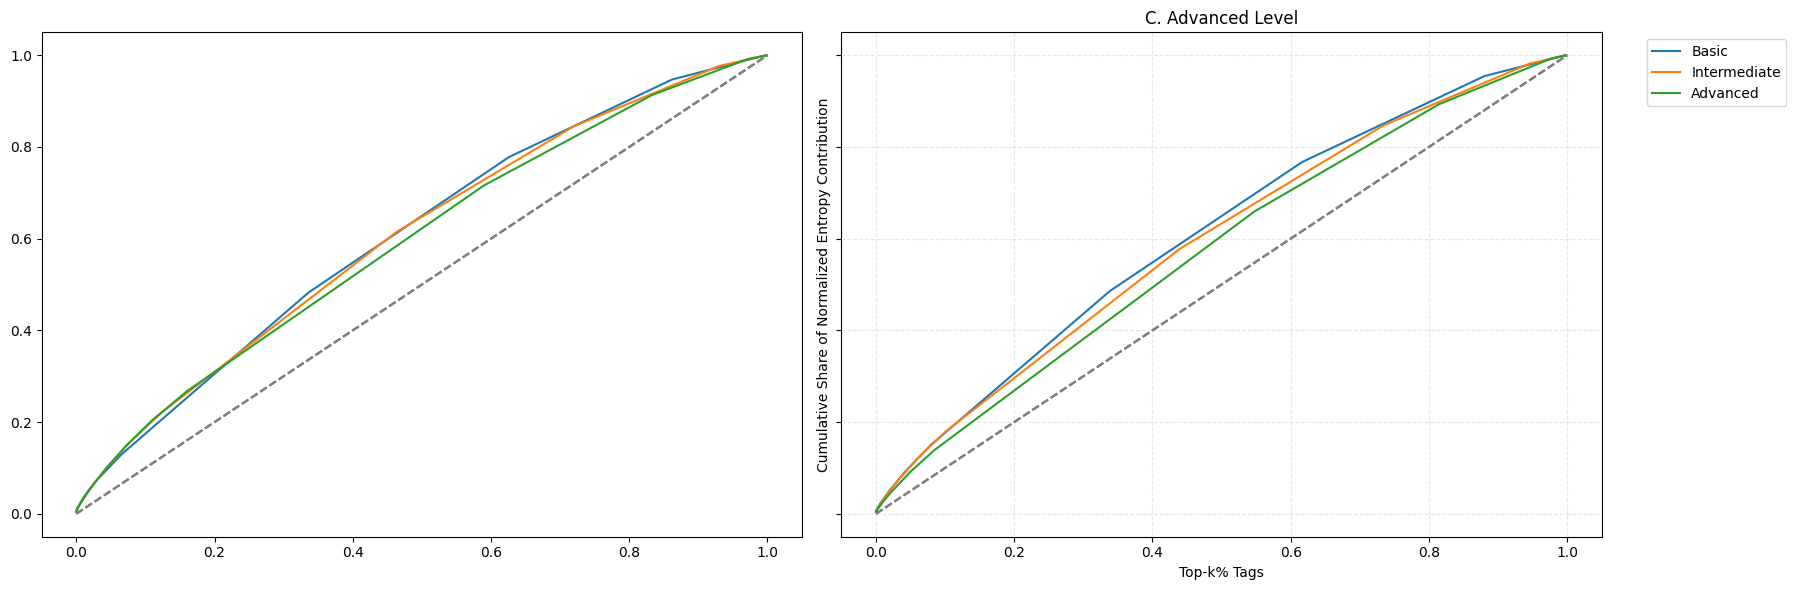

In [105]:
# 시각화 시작
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex=False, sharey=True)

alpha_dict = {'0' : 'A. ', '1' : 'B. ', '2':'C. '}

for idx, diff in enumerate(diff_dict.keys()):
    # diff에 해당하는 데이터프레임을 가져옴
    group_df = n_viz[n_viz['diff'] == diff_dict[diff]]
    bf_vals = np.array(sorted(group_df['entropy'].values, reverse=True))
    bf_cumsum = np.cumsum(bf_vals)
    bf_cumsum /= bf_cumsum[-1]  # 정규화 (총합 = 1)
    bf_x_vals = np.arange(len(bf_cumsum)) / len(bf_cumsum)
    axs[0].plot(bf_x_vals, bf_cumsum, label=diff_dict[diff])
    lims = [0, 1]
    axs[0].plot(lims, lims, color='gray', linestyle='--')
    # shared_keys = set(contrib_before) & set(contrib_after)
    # before_vec = np.array([contrib_before[k] for k in shared_keys])
    # after_vec  = np.array([contrib_after[k]  for k in shared_keys])


    # stat, p = ks_2samp(before_vec, after_vec)

    # axs[idx].text(0.78, 0.02, f'KS-stat: {stat:.3f}\np-value: {p:.3f}',fontsize=10)

    # 대각선 기준선
    

for idx, diff in enumerate(diff_dict.keys()):
    # diff에 해당하는 데이터프레임을 가져옴
    group_df = g_viz[g_viz['diff'] == diff_dict[diff]]
    bf_vals = np.array(sorted(group_df['entropy'].values, reverse=True))
    bf_cumsum = np.cumsum(bf_vals)
    bf_cumsum /= bf_cumsum[-1]  # 정규화 (총합 = 1)
    bf_x_vals = np.arange(len(bf_cumsum)) / len(bf_cumsum)
    axs[1].plot(bf_x_vals, bf_cumsum, label=diff_dict[diff])
    lims = [0, 1]
    axs[1].plot(lims, lims, color='gray', linestyle='--')
    # 스타일
    axs[1].set_xlabel('Top-k% Tags')
    axs[1].set_ylabel('Cumulative Share of Normalized Entropy Contribution')
    axs[1].set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
    axs[1].grid(True, linestyle='--', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()






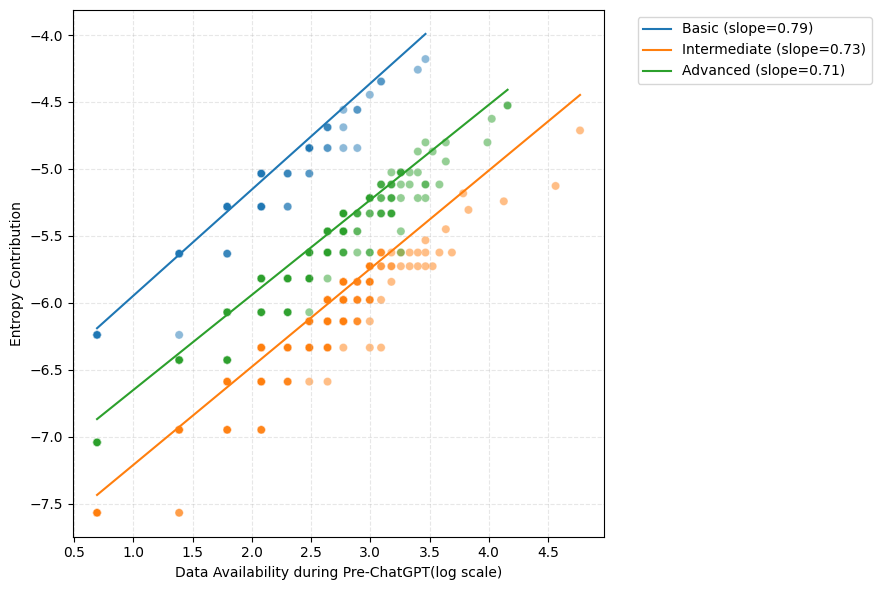

In [106]:
import numpy as np
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots( figsize=(9, 6))

level_order = ['Basic', 'Intermediate', 'Advanced']
color_map = dict(zip(level_order, (colors[0], colors[2], colors[4])))

# 예: 그룹별로 회귀 모델 피팅
for diff in diff_dict.keys():
    # diff에 해당하는 데이터프레임을 가져옴
    group_df = n_viz[n_viz['diff'] == diff_dict[diff]]
    
    # x, y 값 추출
    X = group_df['x'].values.reshape(-1, 1)
    y = group_df['y'].values
    
    # 회귀 모델 피팅
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    # 회귀선 그리기
    x_vals = np.linspace(X.min(), X.max(), 100)
    y_vals = model.predict(x_vals.reshape(-1, 1))
    
    axs.plot(x_vals, y_vals, label=f'{diff_dict[diff]} (slope={slope:.2f})', color=color_map[diff_dict[diff]])
    axs.set_xlabel('Data Availability during Pre-ChatGPT(log scale)')
    axs.set_ylabel('Entropy Contribution')
    # axs.set_title(f'{alpha_dict[diff]}{diff_dict[diff]} Level')
    axs.grid(True, linestyle='--', alpha=0.3)
# 산점도도 함께
sns.scatterplot(data=n_viz, x='x', y='y', hue='diff', palette=color_map, alpha =0.5, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [107]:
n_viz

,tag,count,entropy,diff,x,y
0,openai-api,32,0.015304,Basic,3.465736,-4.179592
1,export-to-csv,30,0.014135,Basic,3.401197,-4.259047
2,python-3.11,22,0.012942,Basic,3.091042,-4.347167
3,post,22,0.012942,Basic,3.091042,-4.347167
4,command,20,0.011724,Basic,2.995732,-4.446021
...,...,...,...,...,...,...
2686,instrumentation,2,0.000874,Advanced,0.693148,-7.041841
2687,google-apps-script,2,0.000874,Advanced,0.693148,-7.041841
2688,graphviz,2,0.000874,Advanced,0.693148,-7.041841
2689,treesitter,2,0.000874,Advanced,0.693148,-7.041841


In [108]:
b_gone = ([x for x in b_dict['0'].items() if x[0] in list(tag_dict['0']['disapperaed'])])
i_gone = ([x for x in b_dict['0'].items() if x[0] in list(tag_dict['1']['disapperaed'])])
a_gone = ([x for x in b_dict['0'].items() if x[0] in list(tag_dict['2']['disapperaed'])])

# list(tag_dict['0']['disapperaed'] )

In [109]:
b_gone.sort(key=lambda x: x[1], reverse=True)

In [110]:
b_gone

[('object', 0.012748819239649172),
 ('scipy', 0.010769314672476231),
 ('xml-parsing', 0.010769314672476231),
 ('python-3.9', 0.010769314672476231),
 ('ip', 0.008705818978594645),
 ('graph', 0.008705818978594645),
 ('python-module', 0.008705818978594645),
 ('glob', 0.008705818978594645),
 ('element', 0.008705818978594645),
 ('tk-toolkit', 0.008705818978594645),
 ('formatting', 0.007635463401462599),
 ('dynamic', 0.007635463401462599),
 ('iteration', 0.007635463401462599),
 ('nonetype', 0.007635463401462599),
 ('title', 0.007635463401462599),
 ('xml', 0.007635463401462599),
 ('webdriverwait', 0.007635463401462599),
 ('os.path', 0.007635463401462599),
 ('join', 0.007635463401462599),
 ('stack', 0.007635463401462599),
 ('utf-8', 0.0065337272068603435),
 ('kivy-language', 0.0065337272068603435),
 ('key-value', 0.0065337272068603435),
 ('templates', 0.0065337272068603435),
 ('pynput', 0.0065337272068603435),
 ('decimal', 0.0065337272068603435),
 ('neural-network', 0.0065337272068603435),
 ('

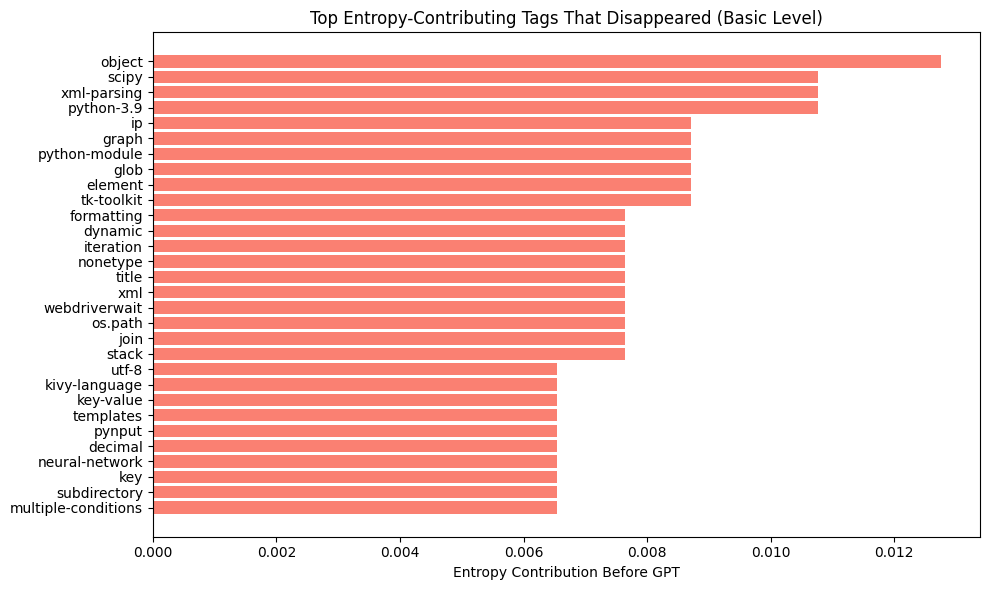

In [111]:
import matplotlib.pyplot as plt

# 샘플 리스트: [(tag, contribution), ...]
tags = [x[0] for x in basic_gone[:30]]
values = [x[1] for x in basic_gone[:30]]

plt.figure(figsize=(10, 6))
plt.barh(tags[::-1], values[::-1], color='salmon')
plt.xlabel("Entropy Contribution Before GPT")
plt.title("Top Entropy-Contributing Tags That Disappeared (Basic Level)")
plt.tight_layout()
plt.show()


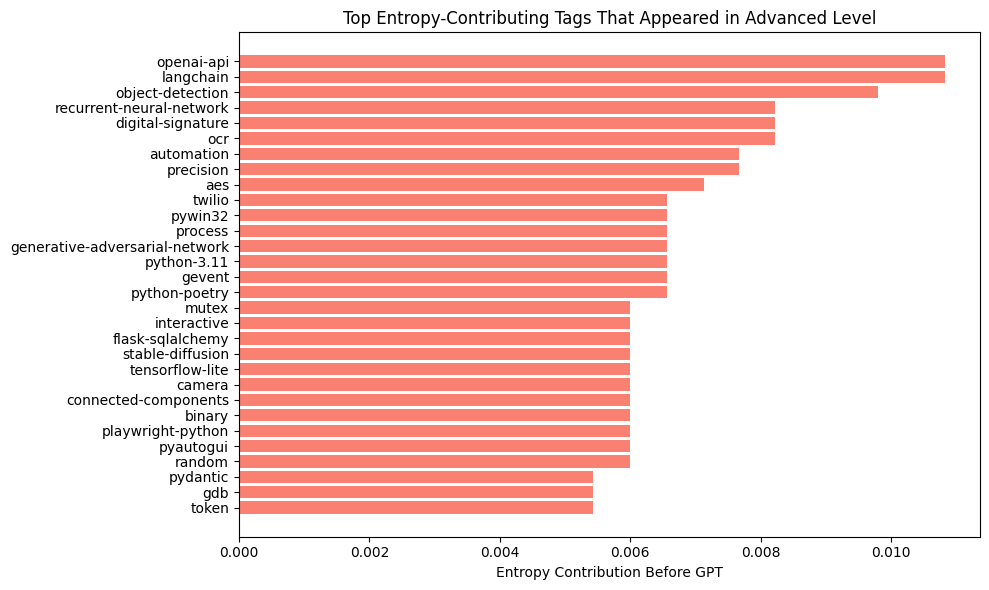

In [112]:
import matplotlib.pyplot as plt

advan_new.sort(key=lambda x: x[1], reverse=True)
# 샘플 리스트: [(tag, contribution), ...]
tags = [x[0] for x in advan_new[:30]]
values = [x[1] for x in advan_new[:30]]

plt.figure(figsize=(10, 6))
plt.barh(tags[::-1], values[::-1], color='salmon')
plt.xlabel("Entropy Contribution Before GPT")
plt.title("Top Entropy-Contributing Tags That Appeared in Advanced Level")
plt.tight_layout()
plt.show()


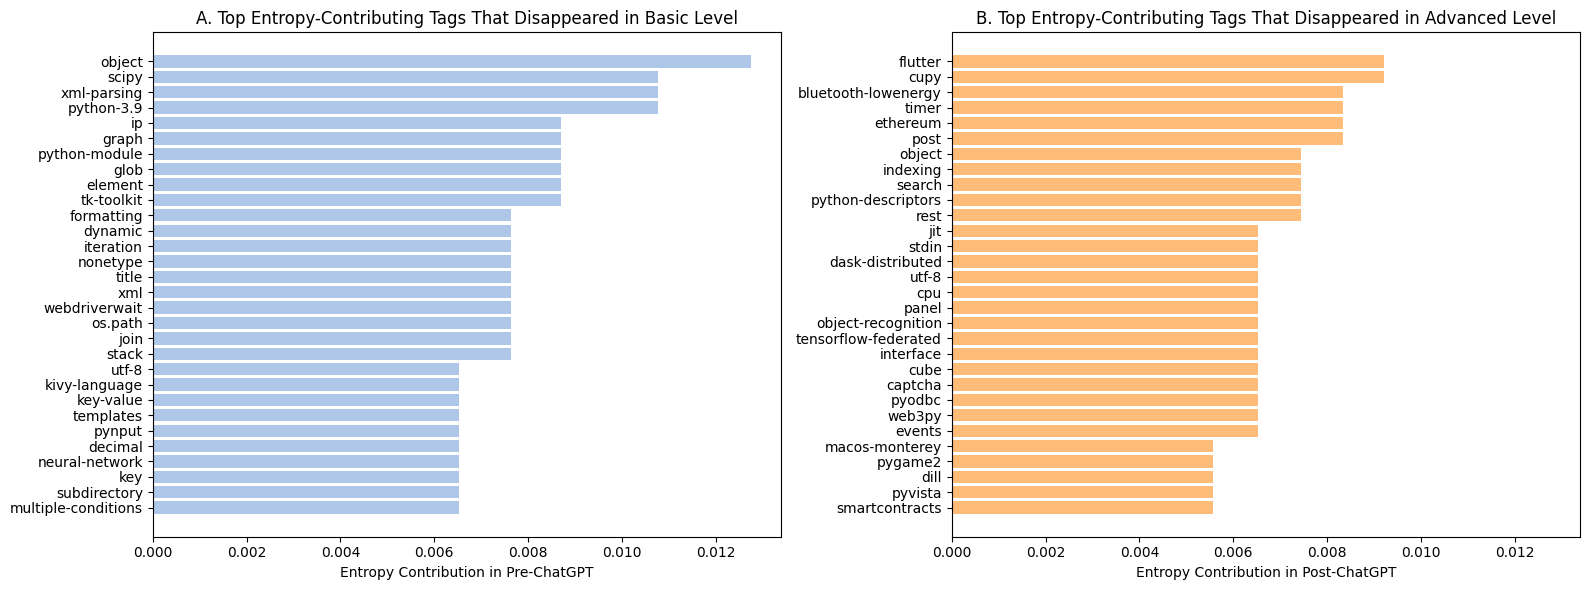

In [113]:
fig, axs = plt.subplots(1, 2 , figsize=(16, 6), sharex=True)


gone_top_tags = [x[0] for x in basic_gone[:30]]
gone_top_values = [x[1] for x in basic_gone[:30]]


# 샘플 리스트: [(tag, contribution), ...]
new_top_tags = [x[0] for x in advan_gone[:30]]
new_top_values = [x[1] for x in advan_gone[:30]]



axs[0].barh(gone_top_tags[::-1], gone_top_values[::-1], color=colors[1])
axs[0].set_xlabel("Entropy Contribution in Pre-ChatGPT")
axs[0].set_title("A. Top Entropy-Contributing Tags That Disappeared in Basic Level")


axs[1].barh(new_top_tags[::-1], new_top_values[::-1], color=colors[3])
axs[1].set_xlabel("Entropy Contribution in Post-ChatGPT")
axs[1].set_title("B. Top Entropy-Contributing Tags That Disappeared in Advanced Level")
plt.tight_layout()
plt.show()


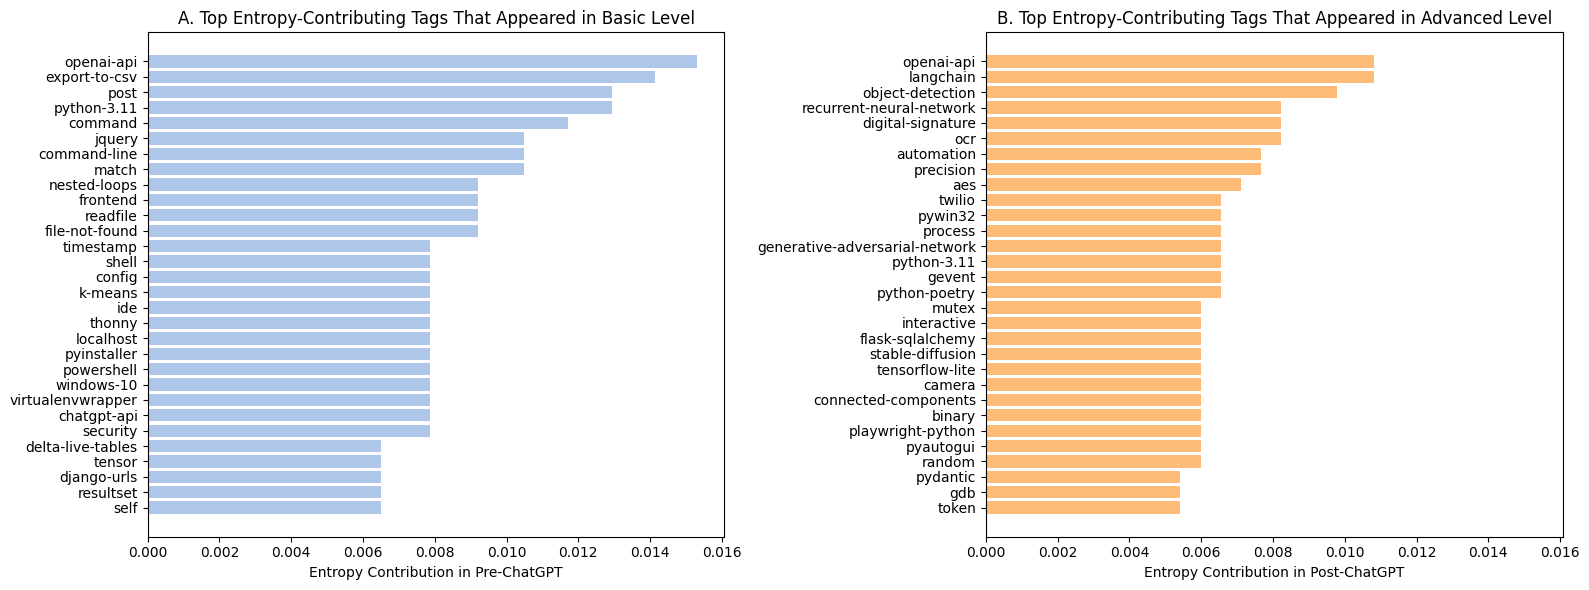

In [114]:
fig, axs = plt.subplots(1, 2 , figsize=(16, 6), sharex=True)


gone_top_tags = [x[0] for x in basic_new[:30]]
gone_top_values = [x[1] for x in basic_new[:30]]


# 샘플 리스트: [(tag, contribution), ...]
new_top_tags = [x[0] for x in advan_new[:30]]
new_top_values = [x[1] for x in advan_new[:30]]



axs[0].barh(gone_top_tags[::-1], gone_top_values[::-1], color=colors[1])
axs[0].set_xlabel("Entropy Contribution in Pre-ChatGPT")
axs[0].set_title("A. Top Entropy-Contributing Tags That Appeared in Basic Level")


axs[1].barh(new_top_tags[::-1], new_top_values[::-1], color=colors[3])
axs[1].set_xlabel("Entropy Contribution in Post-ChatGPT")
axs[1].set_title("B. Top Entropy-Contributing Tags That Appeared in Advanced Level")
plt.tight_layout()
plt.show()


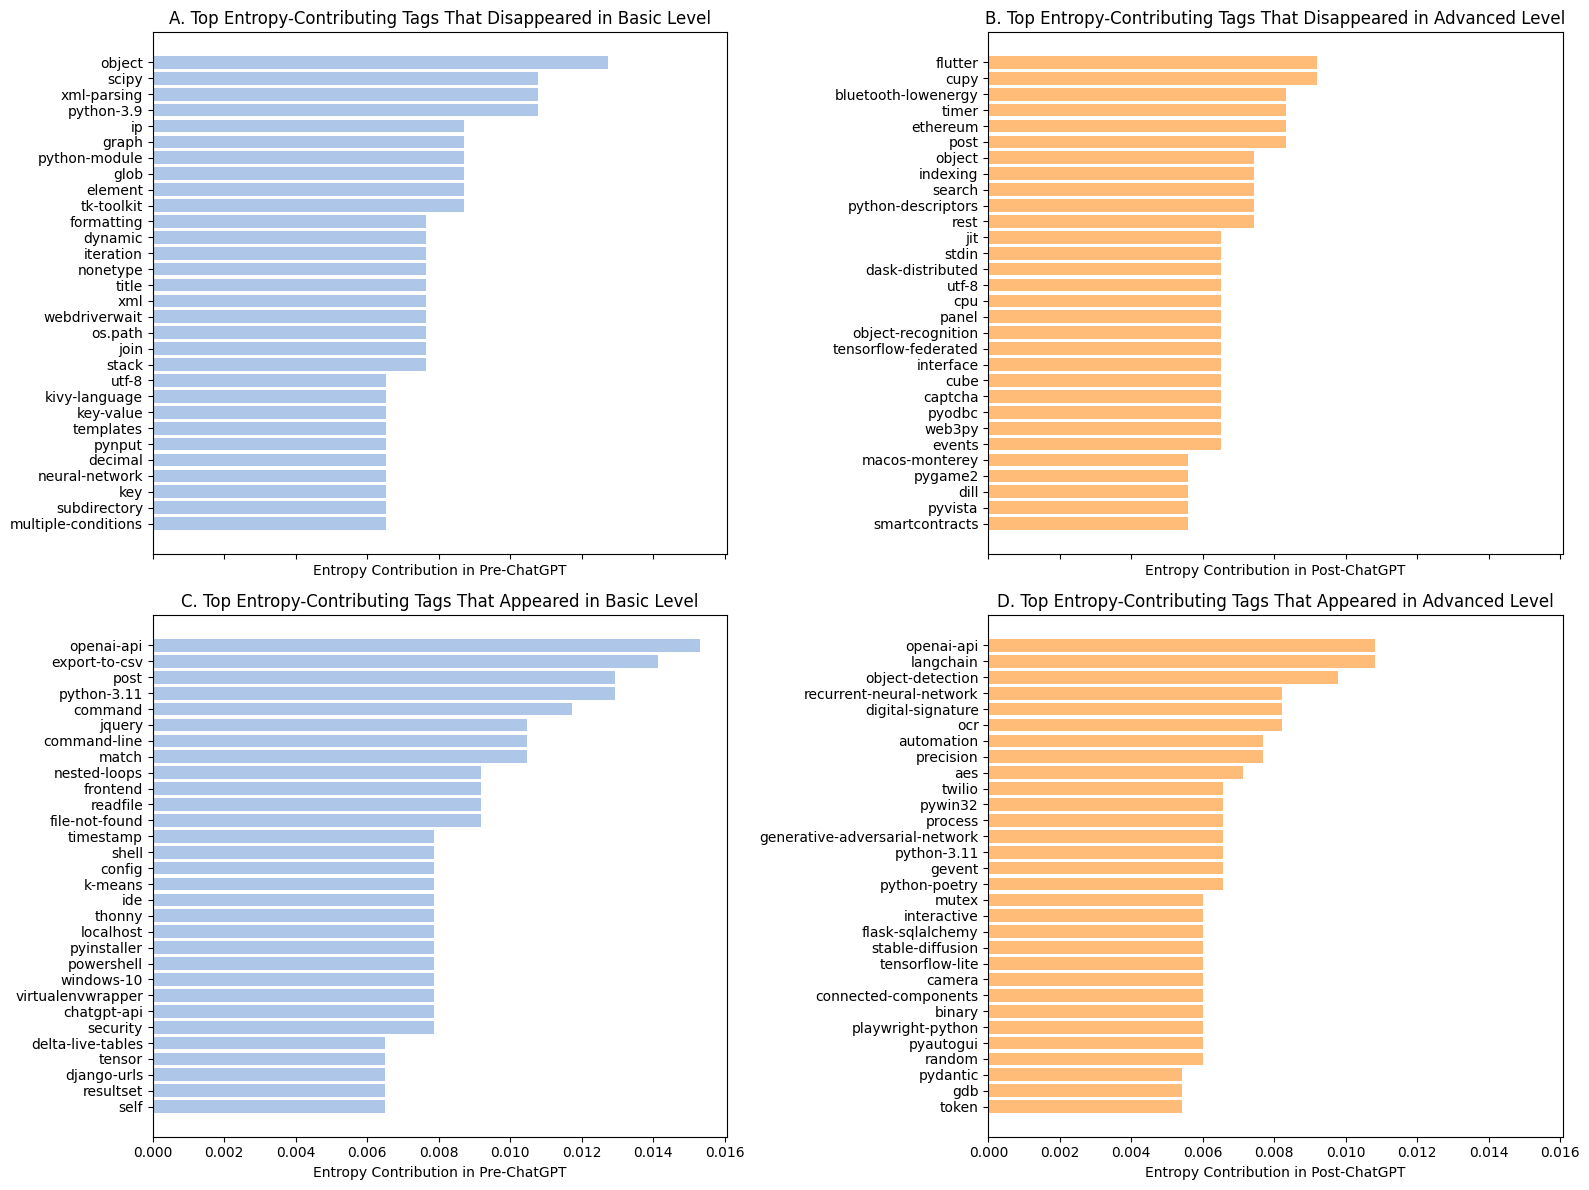

In [115]:
fig, axs = plt.subplots(2, 2 , figsize=(16, 12), sharex=True)


gone_top_tags = [x[0] for x in basic_gone[:30]]
gone_top_values = [x[1] for x in basic_gone[:30]]


# 샘플 리스트: [(tag, contribution), ...]
new_top_tags = [x[0] for x in advan_gone[:30]]
new_top_values = [x[1] for x in advan_gone[:30]]



axs[0][0].barh(gone_top_tags[::-1], gone_top_values[::-1], color=colors[1])
axs[0][0].set_xlabel("Entropy Contribution in Pre-ChatGPT")
axs[0][0].set_title("A. Top Entropy-Contributing Tags That Disappeared in Basic Level")


axs[0][1].barh(new_top_tags[::-1], new_top_values[::-1], color=colors[3])
axs[0][1].set_xlabel("Entropy Contribution in Post-ChatGPT")
axs[0][1].set_title("B. Top Entropy-Contributing Tags That Disappeared in Advanced Level")


gone_top_tags = [x[0] for x in basic_new[:30]]
gone_top_values = [x[1] for x in basic_new[:30]]


# 샘플 리스트: [(tag, contribution), ...]
new_top_tags = [x[0] for x in advan_new[:30]]
new_top_values = [x[1] for x in advan_new[:30]]



axs[1][0].barh(gone_top_tags[::-1], gone_top_values[::-1], color=colors[1])
axs[1][0].set_xlabel("Entropy Contribution in Pre-ChatGPT")
axs[1][0].set_title("C. Top Entropy-Contributing Tags That Appeared in Basic Level")


axs[1][1].barh(new_top_tags[::-1], new_top_values[::-1], color=colors[3])
axs[1][1].set_xlabel("Entropy Contribution in Post-ChatGPT")
axs[1][1].set_title("D. Top Entropy-Contributing Tags That Appeared in Advanced Level")

plt.tight_layout()
plt.savefig(f"{output_dir}Result_Fig9.png", dpi=300, bbox_inches='tight')
plt.show()


In [116]:
import networkx as nx
from collections import Counter

# G는 NetworkX 그래프, gone_tags는 사라진 태그 리스트
neighbor_counter = Counter()


for tag in [x[0] for x in basic_gone]:
    if tag in g_yn_dict['0'][0]:
        neighbors = g_yn_dict['0'][0].neighbors(tag)
        neighbor_counter.update(neighbors)

# 가장 자주 함께 등장한 상위 노드 Top 10
top_neighbors = neighbor_counter.most_common(10)
print(top_neighbors)


[('python', 467), ('python-3.x', 43), ('pandas', 40), ('list', 22), ('dataframe', 19), ('tkinter', 17), ('function', 15), ('jupyter-notebook', 14), ('matplotlib', 14), ('django', 12)]


In [117]:
all_tag_ranks 

NameError: name 'all_tag_ranks' is not defined

In [ ]:
gone_tag_ranks